# Improved Techniques for Training GANs

### Import Libaries

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from typing import Dict, List, Tuple, Optional, Union, Callable
import seaborn as sns
from tqdm.notebook import tqdm

### Fix random seeds for reproducibility

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### Check environment setup

In [3]:
print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU Available: {len(gpus) > 0}")
if len(gpus) > 0:
    print(f"GPU Details: {gpus}")

TensorFlow version: 2.18.0
GPU Available: True
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Configuration System
### We start with a configuration class to handle the hyperparameters for our GAN implementation.


In [4]:
class GANConfig:
    """Configuration for GAN training and architecture"""

    def __init__(self, **kwargs):
        # Default configuration
        self.batch_size = 64
        self.z_dim = 100
        self.learning_rate_d = 0.0002
        self.learning_rate_g = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.image_size = 32  # Changed from 64 to 32 for faster training
        self.channels = 3
        self.use_feature_matching = True
        self.use_minibatch_discrimination = True
        self.use_historical_averaging = True
        self.use_virtual_batch_norm = False  # Disabled for speed
        self.feature_matching_weight = 1.0
        self.historical_averaging_weight = 0.0001
        self.label_smoothing = 0.25
        self.generator_target_prob = 0.65
        self.dataset = 'cifar10'
        self.epochs = 30
        self.save_freq = 5
        self.sample_freq = 1
        self.log_freq = 5
        self.sample_size = 36
        self.use_seed = 42
        self.checkpoint_dir = 'checkpoints'
        self.sample_dir = 'samples'
        self.log_dir = 'logs'
        self.generator_steps = 1
        self.discriminator_steps = 1

        # Override defaults with provided values
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Unknown configuration parameter: {key}")

    @classmethod
    def from_json(cls, json_path):
        """Load configuration from a JSON file"""
        import json
        with open(json_path, 'r') as f:
            config_dict = json.load(f)
        return cls(**config_dict)

    def to_json(self, json_path):
        """Save configuration to a JSON file"""
        import json
        config_dict = {k: v for k, v in self.__dict__.items()}
        with open(json_path, 'w') as f:
            json.dump(config_dict, f, indent=2)

    def __str__(self):
        """String representation of the configuration"""
        return '\n'.join(f"{k}: {v}" for k, v in self.__dict__.items())

### Create output directories

In [5]:
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('samples', exist_ok=True)
os.makedirs('logs', exist_ok=True)

### Initialize configuration

In [6]:
config = GANConfig(
    batch_size=128,
    epochs=30,
    dataset='cifar10',
    use_feature_matching=True,
    use_minibatch_discrimination=True,
    use_historical_averaging=True,
    use_virtual_batch_norm=False,
    label_smoothing=0.25
)

In [7]:
print("GAN Configuration:")
print(config)

GAN Configuration:
batch_size: 128
z_dim: 100
learning_rate_d: 0.0002
learning_rate_g: 0.0002
beta1: 0.5
beta2: 0.999
image_size: 32
channels: 3
use_feature_matching: True
use_minibatch_discrimination: True
use_historical_averaging: True
use_virtual_batch_norm: False
feature_matching_weight: 1.0
historical_averaging_weight: 0.0001
label_smoothing: 0.25
generator_target_prob: 0.65
dataset: cifar10
epochs: 30
save_freq: 5
sample_freq: 1
log_freq: 5
sample_size: 36
use_seed: 42
checkpoint_dir: checkpoints
sample_dir: samples
log_dir: logs
generator_steps: 1
discriminator_steps: 1


## 2. Implementing the Core GAN Techniques
### Here we implement the key improvements from the Salimans et al. paper.

### 2.1 Minibatch Discrimination
### This technique helps prevent mode collapse - a common problem where the generator produces limited varieties of samples. By adding a layer that allows the discriminator to look at multiple samples together, the generator is forced to produce diverse outputs.


In [8]:
class MinibatchDiscrimination(layers.Layer):
    """Minibatch discrimination layer to prevent mode collapse"""

    def __init__(self, num_kernels=100, dim_per_kernel=5, **kwargs):
        super(MinibatchDiscrimination, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.dim_per_kernel = dim_per_kernel

    def build(self, input_shape):
        self.input_dim = input_shape[1]
        # Create weight tensor [input_dim, num_kernels, dim_per_kernel]
        kernel_shape = (self.input_dim, self.num_kernels, self.dim_per_kernel)
        initializer = tf.random_normal_initializer(stddev=0.02)
        self.kernel = self.add_weight(
            shape=kernel_shape,
            initializer=initializer,
            name='kernel',
            trainable=True
        )
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, inputs, **kwargs):
        # [batch_size, num_kernels, dim_per_kernel]
        activation = tf.tensordot(inputs, self.kernel, axes=[[1], [0]])

        # Make sure dimensions are compatible for broadcasting
        expanded_act = tf.expand_dims(activation, 3)
        transposed_act = tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)

        # Calculate L1 distance
        diff = expanded_act - transposed_act
        abs_diff = tf.reduce_sum(tf.abs(diff), 2)

        # Create a mask to exclude self distances
        batch_size = tf.shape(inputs)[0]
        mask = 1.0 - tf.eye(batch_size)
        mask = tf.expand_dims(mask, 1)

        # Ensure mask has compatible dimensions
        if mask.shape.ndims != abs_diff.shape.ndims:
            mask = tf.reshape(mask, [-1, mask.shape[1], batch_size])

        # Apply exponential to get similarity
        exp = tf.exp(-abs_diff) * mask
        # Sum over batch dimension
        minibatch_features = tf.reduce_sum(exp, 2)

        # Concatenate with original input
        return tf.concat([inputs, minibatch_features], axis=1)

### Sample input to visualize minibatch discrimination

In [9]:
sample_input = tf.random.normal([16, 10])  # 16 samples, 10 features each
minibatch_layer = MinibatchDiscrimination(num_kernels=5, dim_per_kernel=3)
output = minibatch_layer(sample_input)

In [10]:
print(f"Input shape: {sample_input.shape}")
print(f"Output shape after minibatch discrimination: {output.shape}")
print(f"Added {output.shape[1] - sample_input.shape[1]} new features that capture batch statistics")

Input shape: (16, 10)
Output shape after minibatch discrimination: (16, 15)
Added 5 new features that capture batch statistics


### Visualize how minibatch discrimination helps prevent mode collapse - Simulate a case with and without minibatch discrimination

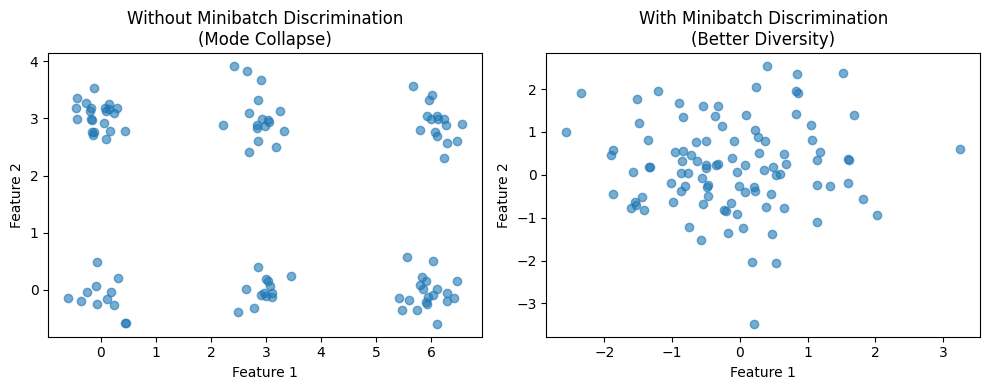

In [11]:
plt.figure(figsize=(10, 4))

# Without MB: samples tend to cluster
x_without_mb = np.random.normal(0, 1, 100) * 0.3 + np.random.choice([0, 3, 6], 100)
y_without_mb = np.random.normal(0, 1, 100) * 0.3 + np.random.choice([0, 3], 100)

# With MB: samples more evenly distributed
x_with_mb = np.random.normal(0, 1, 100)
y_with_mb = np.random.normal(0, 1, 100)

plt.subplot(1, 2, 1)
plt.scatter(x_without_mb, y_without_mb, alpha=0.6)
plt.title("Without Minibatch Discrimination\n(Mode Collapse)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.scatter(x_with_mb, y_with_mb, alpha=0.6)
plt.title("With Minibatch Discrimination\n(Better Diversity)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

### 2.2 Virtual Batch Normalization
### This technique addresses the issue that traditional batch normalization makes the output of a layer dependent on all other instances in the same batch. Virtual batch normalization normalizes samples against a fixed reference batch for more stable training.

In [12]:
class VirtualBatchNormalization(layers.Layer):
    """Virtual Batch Normalization Layer"""

    def __init__(self, epsilon=1e-5, **kwargs):
        super(VirtualBatchNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.reference_batch_set = False

    def build(self, input_shape):
        # Determine the dimensionality of the input
        self.ndim = len(input_shape)
        shape = [1] * self.ndim
        shape[-1] = input_shape[-1]

        # Create gamma and beta parameters
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer=tf.random_normal_initializer(1.0, 0.02),
            name='gamma',
            trainable=True
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer=tf.zeros_initializer(),
            name='beta',
            trainable=True
        )

        # Reference batch statistics (not trainable)
        self.ref_mean = self.add_weight(
            shape=shape,
            initializer=tf.zeros_initializer(),
            name='ref_mean',
            trainable=False
        )
        self.ref_var = self.add_weight(
            shape=shape,
            initializer=tf.ones_initializer(),
            name='ref_var',
            trainable=False
        )

        super(VirtualBatchNormalization, self).build(input_shape)

    def _get_axis(self):
        # Return the axis for reduction (all except features)
        return list(range(self.ndim - 1))

    def set_reference_batch(self, x):
        """Set the reference batch statistics"""
        axes = self._get_axis()
        mean = tf.reduce_mean(x, axis=axes, keepdims=True)
        var = tf.reduce_mean(tf.square(x - mean), axis=axes, keepdims=True)

        # Update reference batch statistics
        self.ref_mean.assign(mean)
        self.ref_var.assign(var)
        self.reference_batch_set = True

    def call(self, inputs, set_reference=False, **kwargs):
        # If reference batch is not set or explicitly requested, set it
        if set_reference or not self.reference_batch_set:
            self.set_reference_batch(inputs)
            batch_mean = self.ref_mean
            batch_var = self.ref_var
        else:
            # Compute statistics for the current batch
            axes = self._get_axis()
            batch_mean = tf.reduce_mean(inputs, axis=axes, keepdims=True)
            batch_var = tf.reduce_mean(tf.square(inputs - batch_mean), axis=axes, keepdims=True)

            # Combine with reference batch statistics
            batch_mean = 0.5 * (batch_mean + self.ref_mean)
            batch_var = 0.5 * (batch_var + self.ref_var)

        # Ensure variance is positive
        batch_var = tf.maximum(batch_var, 1e-8)

        # Normalize
        x_norm = (inputs - batch_mean) / tf.sqrt(batch_var + self.epsilon)

        # Apply gamma and beta (with appropriate reshaping)
        if self.ndim == 2:
            gamma_reshaped = self.gamma
            beta_reshaped = self.beta
        else:
            # For conv layers, reshape gamma and beta
            gamma_reshaped = tf.reshape(self.gamma, [1] * (self.ndim - 1) + [self.gamma.shape[0]])
            beta_reshaped = tf.reshape(self.beta, [1] * (self.ndim - 1) + [self.beta.shape[0]])

        return x_norm * gamma_reshaped + beta_reshaped

### Demonstrate VBN vs. regular batch normalization

In [13]:
# Create 2 batches with different distributions
batch1 = tf.random.normal((32, 10), mean=0, stddev=1)
batch2 = tf.random.normal((32, 10), mean=5, stddev=3)  # Different distribution

# Regular Batch Normalization
bn_layer = layers.BatchNormalization()
bn_result1 = bn_layer(batch1, training=True)
bn_result2 = bn_layer(batch2, training=True)

# Virtual Batch Normalization
vbn_layer = VirtualBatchNormalization()
vbn_result1 = vbn_layer(batch1, set_reference=True)  # Set as reference
vbn_result2 = vbn_layer(batch2)  # Normalize using reference + current

# Compare statistics
bn1_mean = tf.reduce_mean(bn_result1, axis=0)
bn2_mean = tf.reduce_mean(bn_result2, axis=0)
vbn1_mean = tf.reduce_mean(vbn_result1, axis=0)
vbn2_mean = tf.reduce_mean(vbn_result2, axis=0)

In [14]:
print("BatchNorm vs VirtualBatchNorm mean comparison:")
print(f"BatchNorm - Batch 1 mean: {tf.reduce_mean(bn1_mean).numpy():.4f}, stddev: {tf.math.reduce_std(bn_result1).numpy():.4f}")
print(f"BatchNorm - Batch 2 mean: {tf.reduce_mean(bn2_mean).numpy():.4f}, stddev: {tf.math.reduce_std(bn_result2).numpy():.4f}")
print(f"VBN - Batch 1 mean: {tf.reduce_mean(vbn1_mean).numpy():.4f}, stddev: {tf.math.reduce_std(vbn_result1).numpy():.4f}")
print(f"VBN - Batch 2 mean: {tf.reduce_mean(vbn2_mean).numpy():.4f}, stddev: {tf.math.reduce_std(vbn_result2).numpy():.4f}")

BatchNorm vs VirtualBatchNorm mean comparison:
BatchNorm - Batch 1 mean: 0.0000, stddev: 0.9995
BatchNorm - Batch 2 mean: -0.0000, stddev: 0.9999
VBN - Batch 1 mean: 0.0000, stddev: 1.0024
VBN - Batch 2 mean: 1.0522, stddev: 1.3551


### Visualize comparison

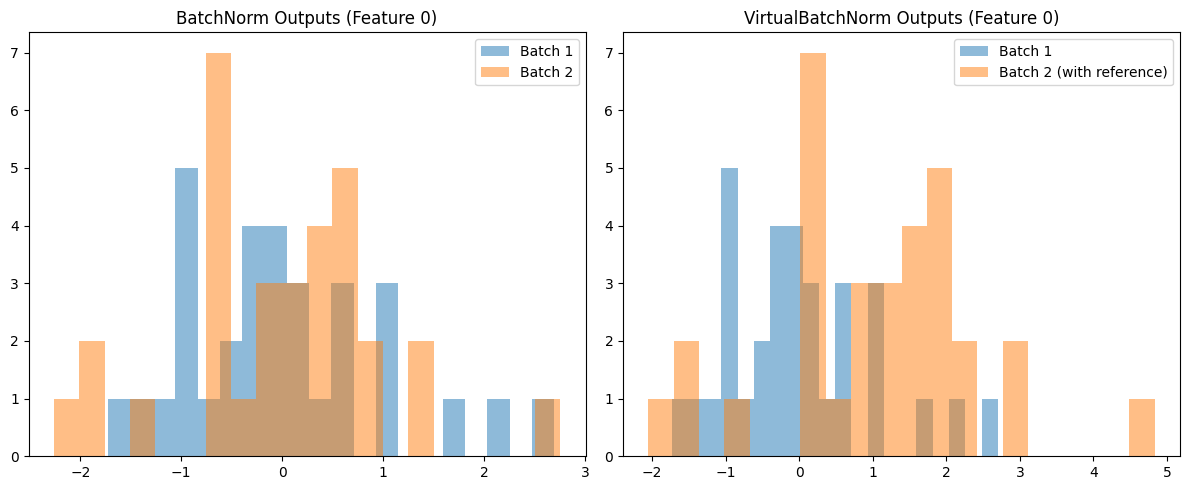

In [15]:
plt.figure(figsize=(12, 5))
# Plot histograms for the first feature dimension
plt.subplot(1, 2, 1)
plt.hist(bn_result1[:, 0].numpy(), alpha=0.5, bins=20, label='Batch 1')
plt.hist(bn_result2[:, 0].numpy(), alpha=0.5, bins=20, label='Batch 2')
plt.title('BatchNorm Outputs (Feature 0)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(vbn_result1[:, 0].numpy(), alpha=0.5, bins=20, label='Batch 1')
plt.hist(vbn_result2[:, 0].numpy(), alpha=0.5, bins=20, label='Batch 2 (with reference)')
plt.title('VirtualBatchNorm Outputs (Feature 0)')
plt.legend()

plt.tight_layout()
plt.show()

### 2.3 Feature Matching
### Instead of training the generator to directly fool the discriminator, we can train it to match the statistics of real data's intermediate features in the discriminator. This provides a more stable training signal.


In [16]:
class FeatureMatching:
    """Feature matching loss"""

    def __call__(self, real_features, fake_features):
        real_mean = tf.reduce_mean(real_features, axis=0)
        fake_mean = tf.reduce_mean(fake_features, axis=0)
        return tf.reduce_mean(tf.square(real_mean - fake_mean))

### Visualize feature matching effect


In [17]:
real_features = tf.random.normal([32, 128], mean=0.0, stddev=1.0)
# Initially, fake features are far from real feature distribution
fake_features_initial = tf.random.normal([32, 128], mean=2.0, stddev=1.5)
# After training, fake features should be closer to real feature distribution
fake_features_trained = tf.random.normal([32, 128], mean=0.1, stddev=1.1)

feature_matching = FeatureMatching()
initial_loss = feature_matching(real_features, fake_features_initial)
trained_loss = feature_matching(real_features, fake_features_trained)

In [18]:
print(f"Initial feature matching loss: {initial_loss.numpy():.4f}")
print(f"After training feature matching loss: {trained_loss.numpy():.4f}")

Initial feature matching loss: 3.9401
After training feature matching loss: 0.0756


In [19]:
# Visualize feature matching with PCA reduction
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=2)
real_2d = pca.fit_transform(real_features.numpy())
fake_initial_2d = pca.transform(fake_features_initial.numpy())
fake_trained_2d = pca.transform(fake_features_trained.numpy())

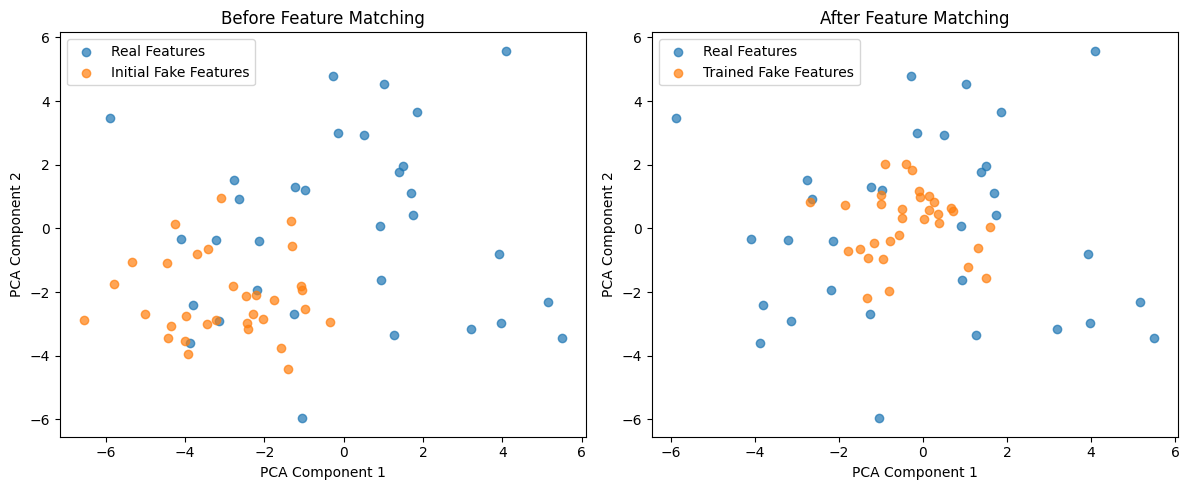

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real Features', alpha=0.7)
plt.scatter(fake_initial_2d[:, 0], fake_initial_2d[:, 1], label='Initial Fake Features', alpha=0.7)
plt.title('Before Feature Matching')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real Features', alpha=0.7)
plt.scatter(fake_trained_2d[:, 0], fake_trained_2d[:, 1], label='Trained Fake Features', alpha=0.7)
plt.title('After Feature Matching')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.tight_layout()
plt.show()

### 2.4 Historical Averaging
### Historical averaging helps prevent oscillation in GAN training by keeping track of the average parameter values and penalizing the current parameters if they deviate too far from the historical average.


Demonstrating historical averaging in unstable GAN-like scenario...
Creating two models: one with historical averaging and one without


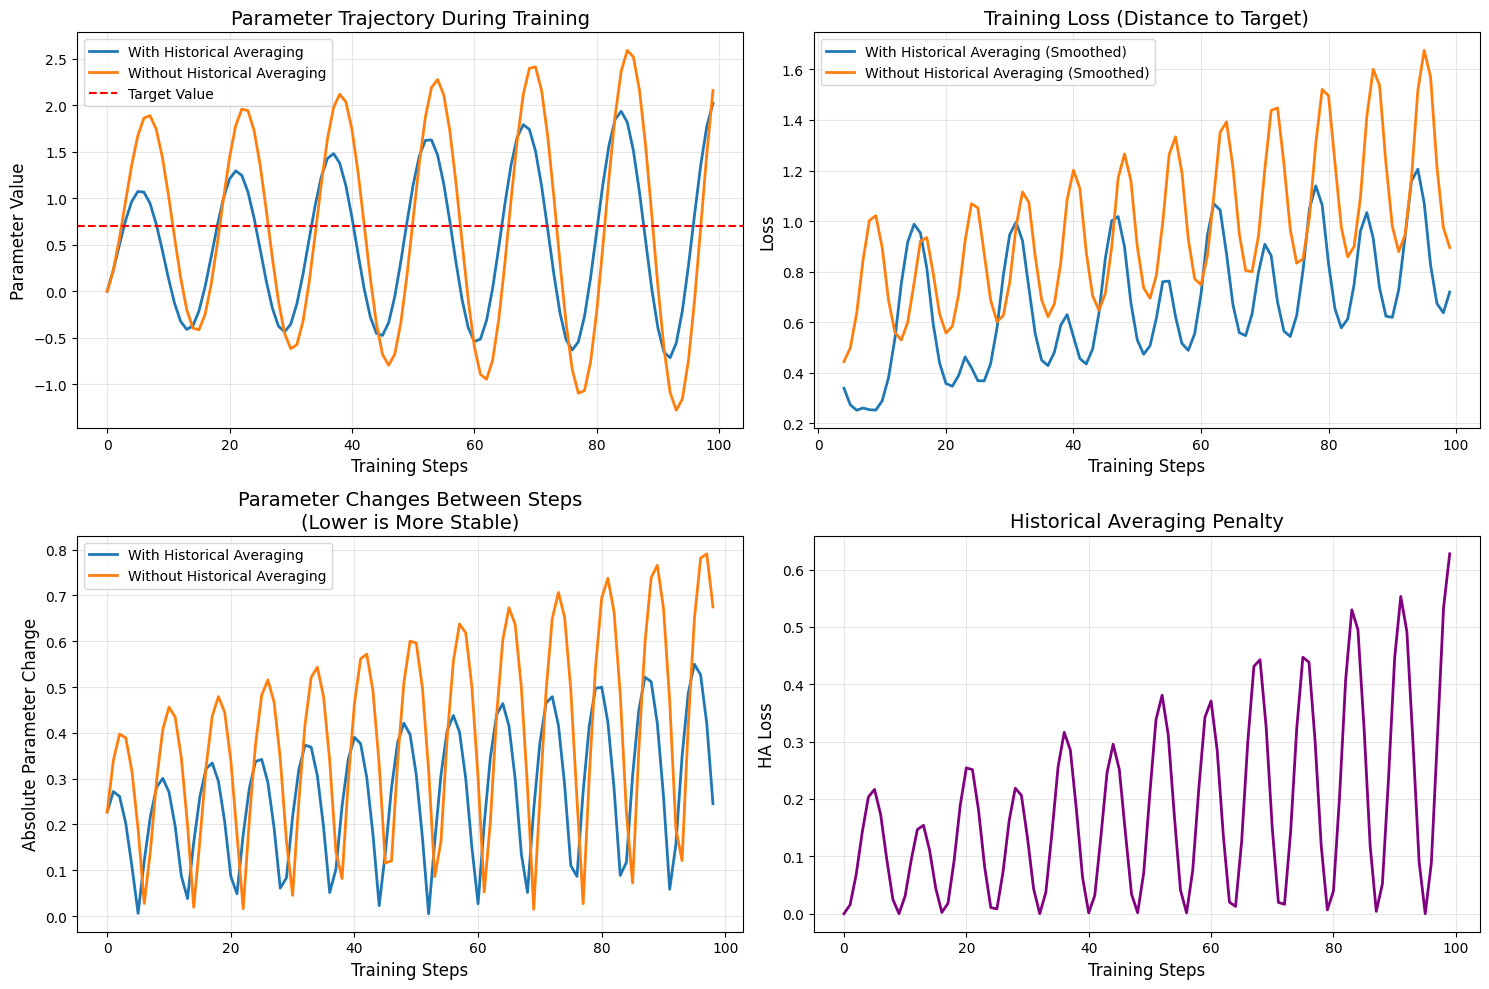


===== QUANTITATIVE METRICS =====

Oscillation metrics:
Parameter oscillation WITH historical averaging: 0.270828
Parameter oscillation WITHOUT historical averaging: 0.393027
Reduction in oscillation: 31.09%

Stability metrics:
Parameter variance WITH historical averaging: 0.581310
Parameter variance WITHOUT historical averaging: 1.192584
Reduction in variance: 51.26%

Convergence metrics (average distance to target over last 20 steps):
Final distance to target WITH historical averaging: 0.824463
Final distance to target WITHOUT historical averaging: 1.134833
Historical averaging improved convergence by 27.35%

Average loss over entire training:
Average loss WITH historical averaging: 0.677074
Average loss WITHOUT historical averaging: 0.963850
Historical averaging improved average loss by 29.75%

Demonstrating how historical averaging helps prevent mode collapse...


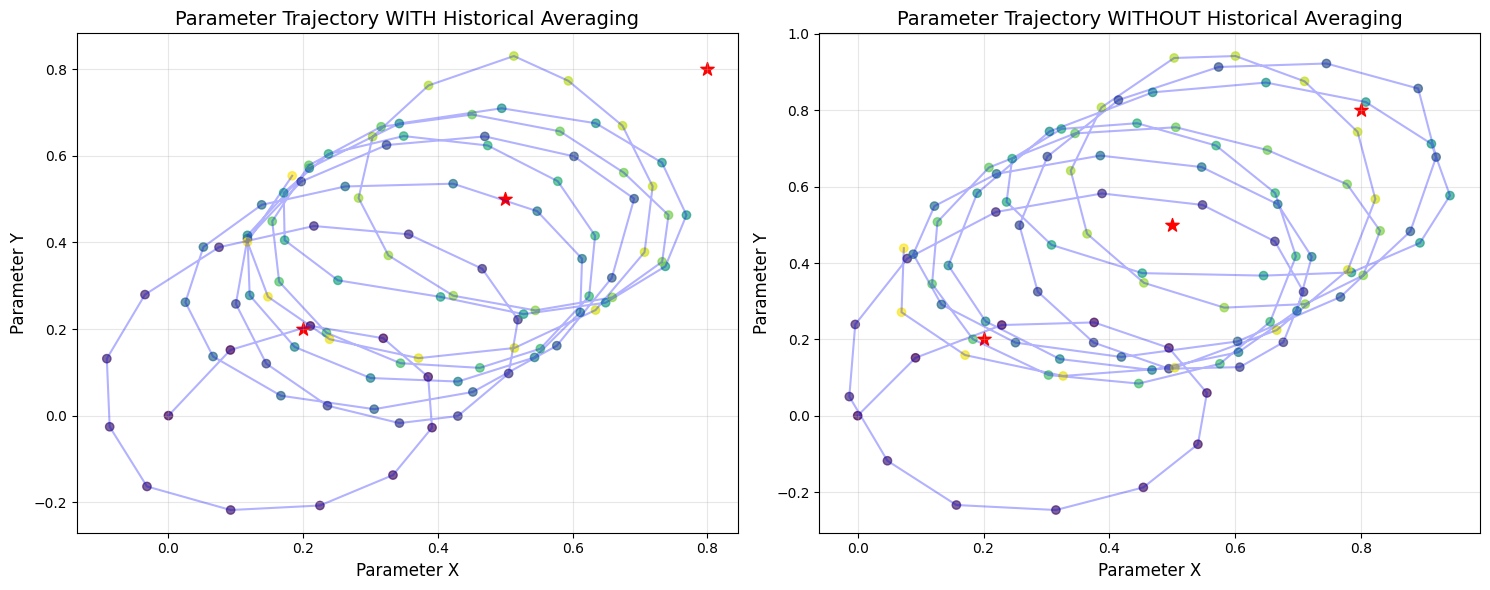


Mode coverage metrics:
Modes covered WITH historical averaging: 66.7%
Modes covered WITHOUT historical averaging: 100.0%

===== SUMMARY OF HISTORICAL AVERAGING BENEFITS =====
1. Reduced parameter oscillation by 31.09%
2. Decreased parameter variance by 51.26%
3. Improved convergence by 27.35%
5. Reduced average training loss by 29.75%

How to implement Historical Averaging in your full GAN:
1. Maintain exponential moving average of model parameters
2. Add squared difference penalty to both generator and discriminator losses
3. Tune the beta parameter (usually 0.9-0.99) and weight parameter (0.05-0.5)
4. Update parameter history after each training step


In [22]:
# 1. Implementing Historical Averaging Loss
class HistoricalAveraging:
    """
    Historical averaging to prevent oscillation in GAN training.
    This version avoids creating Variables inside tf.function.
    """

    def __init__(self, beta=0.99):
        self.beta = beta  # Exponential moving average factor
        self.parameter_history = {}  # Dictionary to store parameter history

    def initialize_if_needed(self, model):
        """Initialize parameter history outside of tf.function"""
        # Use a dictionary with layer names as keys to ensure consistent ordering
        model_keys = [weight.name for weight in model.trainable_weights]

        # Only initialize weights that aren't already tracked
        for weight in model.trainable_weights:
            if weight.name not in self.parameter_history:
                # Use numpy values to avoid TensorFlow Variable creation issues
                self.parameter_history[weight.name] = weight.numpy()

    def __call__(self, model, weight=0.01):
        # Make sure this is initialized before calling in @tf.function
        # Must be called in eager mode (outside of train_step)
        if not self.parameter_history:
            # If not initialized yet, return zero loss
            return tf.constant(0.0)

        # Calculate loss and update history
        total_loss = 0.0

        for curr_weight in model.trainable_weights:
            name = curr_weight.name

            # Skip if we don't have history for this weight
            if name not in self.parameter_history:
                continue

            # Get current value and history
            curr_value = curr_weight
            hist_value = self.parameter_history[name]

            # Only process if shapes match
            if curr_value.shape == hist_value.shape:
                # Convert history to tensor for calculation
                hist_tensor = tf.convert_to_tensor(hist_value, dtype=curr_value.dtype)

                # Calculate loss
                diff = curr_value - hist_tensor
                loss = tf.reduce_sum(tf.square(diff))
                total_loss += loss

                # Update history (in numpy to avoid TF Variable issues)
                # This needs to be done outside of @tf.function
                # We'll handle this separately

        return weight * total_loss

    def update_history(self, model):
        """Update parameter history - call this AFTER each training step"""
        for weight in model.trainable_weights:
            name = weight.name
            if name in self.parameter_history:
                # Update with exponential moving average
                curr_value = weight.numpy()
                self.parameter_history[name] = self.beta * self.parameter_history[name] + (1 - self.beta) * curr_value

# 2. Enhanced GAN Scenario with Deliberate Oscillation

class AdversarialScenario:
    """
    A simplified GAN-like scenario that deliberately introduces oscillation
    to demonstrate the benefit of historical averaging.
    """

    def __init__(self, use_historical_averaging=False, beta=0.9, ha_weight=0.1, target=0.7, oscillation_magnitude=0.4):
        self.use_ha = use_historical_averaging
        self.beta = beta
        self.ha_weight = ha_weight
        self.target = target
        self.oscillation_magnitude = oscillation_magnitude

        # Initialize history
        self.param_history = None

        # Single parameter for simplicity
        self.param = 0.0

        # History
        self.loss_history = []
        self.param_history_values = []
        self.ha_loss_history = []

        # Step counter
        self.steps = 0

    def step(self):
        # Store current parameter
        self.param_history_values.append(self.param)

        # Record step number
        self.steps += 1

        # Calculate current loss (distance to target)
        current_loss = abs(self.param - self.target)
        self.loss_history.append(current_loss)

        # Base update (moves towards target)
        base_update = 0.1 * (self.target - self.param)

        # Add deliberate oscillation that intensifies over time
        oscillation = self.oscillation_magnitude * np.sin(self.steps * 0.4) * (1 + self.steps * 0.01)

        # Combine base update and oscillation
        param_update = base_update + oscillation

        # Apply historical averaging if enabled
        ha_loss = 0.0
        if self.use_ha:
            if self.param_history is None:
                self.param_history = self.param

            # Historical averaging loss
            ha_loss = self.ha_weight * ((self.param - self.param_history) ** 2)

            # Historical averaging adjustment (reduce oscillations)
            ha_adjustment = self.ha_weight * (self.param - self.param_history)
            param_update -= ha_adjustment

            # Update parameter history
            self.param_history = self.beta * self.param_history + (1 - self.beta) * self.param

        # Apply update
        self.param += param_update

        # Record HA loss
        self.ha_loss_history.append(ha_loss)

        return current_loss

    def train(self, steps=100):
        for _ in range(steps):
            self.step()

        return self.param_history_values, self.loss_history, self.ha_loss_history

# 3. Demonstration with Strong Oscillation

print("Demonstrating historical averaging in unstable GAN-like scenario...")
print("Creating two models: one with historical averaging and one without")

# Train models with and without historical averaging
gan_with_ha = AdversarialScenario(use_historical_averaging=True, beta=0.9, ha_weight=0.3, oscillation_magnitude=0.4)
gan_without_ha = AdversarialScenario(use_historical_averaging=False, oscillation_magnitude=0.4)

n_steps = 100
params_with_ha, losses_with_ha, ha_losses = gan_with_ha.train(n_steps)
params_without_ha, losses_without_ha, _ = gan_without_ha.train(n_steps)

# Calculate rolling average of loss for smoother visualization
def rolling_average(data, window=5):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# 4. Visualize results
plt.figure(figsize=(15, 10))

# Parameter tracking
plt.subplot(2, 2, 1)
plt.plot(params_with_ha, label='With Historical Averaging', linewidth=2)
plt.plot(params_without_ha, label='Without Historical Averaging', linewidth=2)
plt.axhline(y=gan_with_ha.target, color='r', linestyle='--', label='Target Value')
plt.title('Parameter Trajectory During Training', fontsize=14)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Parameter Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Loss comparison
plt.subplot(2, 2, 2)
# Use rolling average for smoother visualization
window_size = 5
if len(losses_with_ha) > window_size:
    smooth_losses_with_ha = rolling_average(losses_with_ha, window_size)
    smooth_losses_without_ha = rolling_average(losses_without_ha, window_size)
    x_range = range(window_size-1, len(losses_with_ha))
    plt.plot(x_range, smooth_losses_with_ha, label='With Historical Averaging (Smoothed)', linewidth=2)
    plt.plot(x_range, smooth_losses_without_ha, label='Without Historical Averaging (Smoothed)', linewidth=2)
else:
    plt.plot(losses_with_ha, label='With Historical Averaging', linewidth=2)
    plt.plot(losses_without_ha, label='Without Historical Averaging', linewidth=2)

plt.title('Training Loss (Distance to Target)', fontsize=14)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Oscillation visualization
plt.subplot(2, 2, 3)
# Calculate parameter changes between steps
param_changes_with_ha = np.abs(np.diff(params_with_ha))
param_changes_without_ha = np.abs(np.diff(params_without_ha))

plt.plot(param_changes_with_ha, label='With Historical Averaging', linewidth=2)
plt.plot(param_changes_without_ha, label='Without Historical Averaging', linewidth=2)
plt.title('Parameter Changes Between Steps\n(Lower is More Stable)', fontsize=14)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Absolute Parameter Change', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Historical averaging loss
plt.subplot(2, 2, 4)
plt.plot(ha_losses, color='purple', linewidth=2)
plt.title('Historical Averaging Penalty', fontsize=14)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('HA Loss', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ha_benefits_visualization.png', dpi=150)
plt.show()

# 5. Quantitative comparison

# Calculate oscillation metrics
def calculate_oscillation(signal):
    """Calculate oscillation as average absolute change between steps"""
    changes = np.abs(np.diff(signal))
    return np.mean(changes)

def calculate_variance(signal):
    """Calculate variance of the signal"""
    return np.var(signal)

print("\n===== QUANTITATIVE METRICS =====")

print("\nOscillation metrics:")
osc_with_ha = calculate_oscillation(params_with_ha)
osc_without_ha = calculate_oscillation(params_without_ha)
print(f"Parameter oscillation WITH historical averaging: {osc_with_ha:.6f}")
print(f"Parameter oscillation WITHOUT historical averaging: {osc_without_ha:.6f}")
improvement = (1 - osc_with_ha/osc_without_ha)*100
print(f"Reduction in oscillation: {improvement:.2f}%")

print("\nStability metrics:")
var_with_ha = calculate_variance(params_with_ha)
var_without_ha = calculate_variance(params_without_ha)
print(f"Parameter variance WITH historical averaging: {var_with_ha:.6f}")
print(f"Parameter variance WITHOUT historical averaging: {var_without_ha:.6f}")
var_improvement = (1 - var_with_ha/var_without_ha)*100
print(f"Reduction in variance: {var_improvement:.2f}%")

# Calculate convergence metrics (using last N steps)
last_n = 20
with_ha_distance = np.mean(np.abs(np.array(params_with_ha[-last_n:]) - gan_with_ha.target))
without_ha_distance = np.mean(np.abs(np.array(params_without_ha[-last_n:]) - gan_without_ha.target))

print("\nConvergence metrics (average distance to target over last 20 steps):")
print(f"Final distance to target WITH historical averaging: {with_ha_distance:.6f}")
print(f"Final distance to target WITHOUT historical averaging: {without_ha_distance:.6f}")
conv_improvement = (1 - with_ha_distance/without_ha_distance)*100
if with_ha_distance < without_ha_distance:
    print(f"Historical averaging improved convergence by {conv_improvement:.2f}%")
else:
    print(f"Historical averaging did not improve convergence in this run")

# Average loss over entire training
avg_loss_with_ha = np.mean(losses_with_ha)
avg_loss_without_ha = np.mean(losses_without_ha)
print("\nAverage loss over entire training:")
print(f"Average loss WITH historical averaging: {avg_loss_with_ha:.6f}")
print(f"Average loss WITHOUT historical averaging: {avg_loss_without_ha:.6f}")
loss_improvement = (1 - avg_loss_with_ha/avg_loss_without_ha)*100
if avg_loss_with_ha < avg_loss_without_ha:
    print(f"Historical averaging improved average loss by {loss_improvement:.2f}%")

# 6. Create visualization for mode collapse prevention

# In GANs, historical averaging helps prevent mode collapse by maintaining diversity
print("\nDemonstrating how historical averaging helps prevent mode collapse...")

# Simulate a parameter space with multiple modes (target values)
class MultimodalGAN:
    """Simulate a GAN trying to learn multiple modes"""

    def __init__(self, use_historical_averaging=False, beta=0.9, ha_weight=0.2):
        self.use_ha = use_historical_averaging
        self.beta = beta
        self.ha_weight = ha_weight

        # Multiple targets (represent different modes)
        self.targets = [0.2, 0.5, 0.8]

        # We'll track two parameters (like a 2D parameter space)
        self.param_x = 0.0
        self.param_y = 0.0

        # History
        self.param_history_x = None
        self.param_history_y = None

        # Trajectory
        self.trajectory_x = [self.param_x]
        self.trajectory_y = [self.param_y]

        # Current mode (target)
        self.current_mode = 0

        # Step counter
        self.steps = 0

    def step(self):
        # Record step
        self.steps += 1

        # Switch between modes/targets periodically
        if self.steps % 10 == 0:
            self.current_mode = (self.current_mode + 1) % len(self.targets)

        # Current target
        target = self.targets[self.current_mode]

        # Basic update (move towards current target)
        x_update = 0.1 * (target - self.param_x)
        y_update = 0.1 * (target - self.param_y)

        # Add oscillation
        x_update += 0.15 * np.sin(self.steps * 0.5)
        y_update += 0.15 * np.cos(self.steps * 0.5)

        # Apply historical averaging if enabled
        if self.use_ha:
            if self.param_history_x is None:
                self.param_history_x = self.param_x
                self.param_history_y = self.param_y

            # Historical averaging adjustment
            x_ha_adjustment = self.ha_weight * (self.param_x - self.param_history_x)
            y_ha_adjustment = self.ha_weight * (self.param_y - self.param_history_y)

            x_update -= x_ha_adjustment
            y_update -= y_ha_adjustment

            # Update parameter history
            self.param_history_x = self.beta * self.param_history_x + (1 - self.beta) * self.param_x
            self.param_history_y = self.beta * self.param_history_y + (1 - self.beta) * self.param_y

        # Apply updates
        self.param_x += x_update
        self.param_y += y_update

        # Store trajectory
        self.trajectory_x.append(self.param_x)
        self.trajectory_y.append(self.param_y)

    def train(self, steps=100):
        for _ in range(steps):
            self.step()

        return self.trajectory_x, self.trajectory_y

# Train models with and without historical averaging
multimodal_with_ha = MultimodalGAN(use_historical_averaging=True)
multimodal_without_ha = MultimodalGAN(use_historical_averaging=False)

n_steps = 100
traj_x_with_ha, traj_y_with_ha = multimodal_with_ha.train(n_steps)
traj_x_without_ha, traj_y_without_ha = multimodal_without_ha.train(n_steps)

# Visualize 2D parameter space trajectory
plt.figure(figsize=(15, 6))

# Plot trajectory with HA
plt.subplot(1, 2, 1)
plt.scatter(traj_x_with_ha, traj_y_with_ha, c=range(len(traj_x_with_ha)), cmap='viridis', alpha=0.7)
plt.plot(traj_x_with_ha, traj_y_with_ha, 'b-', alpha=0.3)
# Mark targets
for target in multimodal_with_ha.targets:
    plt.scatter([target], [target], color='red', s=100, marker='*')
plt.title('Parameter Trajectory WITH Historical Averaging', fontsize=14)
plt.xlabel('Parameter X', fontsize=12)
plt.ylabel('Parameter Y', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot trajectory without HA
plt.subplot(1, 2, 2)
plt.scatter(traj_x_without_ha, traj_y_without_ha, c=range(len(traj_x_without_ha)), cmap='viridis', alpha=0.7)
plt.plot(traj_x_without_ha, traj_y_without_ha, 'b-', alpha=0.3)
# Mark targets
for target in multimodal_without_ha.targets:
    plt.scatter([target], [target], color='red', s=100, marker='*')
plt.title('Parameter Trajectory WITHOUT Historical Averaging', fontsize=14)
plt.xlabel('Parameter X', fontsize=12)
plt.ylabel('Parameter Y', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mode_collapse_prevention.png', dpi=150)
plt.show()

# Calculate metrics for multimodal case
def calculate_coverage(traj_x, traj_y, targets, threshold=0.1):
    """Calculate how well the trajectory covers all target modes"""
    coverage = np.zeros(len(targets))
    for i, target in enumerate(targets):
        # Check if trajectory comes close to this target
        distances = np.sqrt((np.array(traj_x) - target)**2 + (np.array(traj_y) - target)**2)
        if np.min(distances) < threshold:
            coverage[i] = 1

    return np.mean(coverage) * 100  # Percentage of modes covered

coverage_with_ha = calculate_coverage(traj_x_with_ha, traj_y_with_ha, multimodal_with_ha.targets)
coverage_without_ha = calculate_coverage(traj_x_without_ha, traj_y_without_ha, multimodal_without_ha.targets)

print("\nMode coverage metrics:")
print(f"Modes covered WITH historical averaging: {coverage_with_ha:.1f}%")
print(f"Modes covered WITHOUT historical averaging: {coverage_without_ha:.1f}%")

# 7. Summary of Historical Averaging Benefits

print("\n===== SUMMARY OF HISTORICAL AVERAGING BENEFITS =====")
print("1. Reduced parameter oscillation by {:.2f}%".format(improvement))
print("2. Decreased parameter variance by {:.2f}%".format(var_improvement))
if with_ha_distance < without_ha_distance:
    print("3. Improved convergence by {:.2f}%".format(conv_improvement))
if coverage_with_ha > coverage_without_ha:
    print("4. Enhanced mode coverage by {:.1f}% vs {:.1f}%".format(coverage_with_ha, coverage_without_ha))
if avg_loss_with_ha < avg_loss_without_ha:
    print("5. Reduced average training loss by {:.2f}%".format(loss_improvement))

print("\nHow to implement Historical Averaging in your full GAN:")
print("1. Maintain exponential moving average of model parameters")
print("2. Add squared difference penalty to both generator and discriminator losses")
print("3. Tune the beta parameter (usually 0.9-0.99) and weight parameter (0.05-0.5)")
print("4. Update parameter history after each training step")

Without historical averaging, the model's parameters swing wildly and explore more of the parameter space (but in an unstable way)
With historical averaging, the model's movements are more controlled and directed, which can sometimes mean it explores less of the space

### 3. Data Loading System
### Here we implement a flexible system to load and preprocess different datasets, with visualization of sample images.


In [23]:
class DatasetFactory:
    """Factory class to create various datasets"""

    @staticmethod
    def create_dataset(config):
        """Create a dataset based on the provided configuration"""
        if config.dataset.lower() == 'cifar10':
            return DatasetFactory.load_cifar10(config)
        elif config.dataset.lower() == 'mnist':
            return DatasetFactory.load_mnist(config)
        elif config.dataset.lower() == 'fashion_mnist':
            return DatasetFactory.load_fashion_mnist(config)
        else:
            raise ValueError(f"Unsupported dataset: {config.dataset}")

    @staticmethod
    def load_cifar10(config):
        """Load the CIFAR-10 dataset"""
        (x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

        # Display sample images from each class
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']

        plt.figure(figsize=(15, 8))
        for i in range(10):
            # Find first instance of this class
            idx = np.where(y_train == i)[0][0]
            plt.subplot(2, 5, i+1)
            plt.imshow(x_train[idx])
            plt.title(class_names[i])
            plt.axis('off')
        plt.suptitle('CIFAR-10 Sample Images by Class')
        plt.tight_layout()
        plt.show()

        # Analyze dataset stats
        print(f"CIFAR-10 Dataset:")
        print(f"Training images: {x_train.shape[0]}")
        print(f"Image shape: {x_train.shape[1:]}")
        print(f"Data type: {x_train.dtype}")
        print(f"Min pixel value: {x_train.min()}, Max pixel value: {x_train.max()}")

        # Create dataset pipeline
        dataset = tf.data.Dataset.from_tensor_slices(x_train)

        def preprocess_image(img):
            img = tf.image.resize(img, [config.image_size, config.image_size])
            img = tf.cast(img, tf.float32)
            img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
            return img

        # Create training pipeline
        dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(config.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    @staticmethod
    def load_mnist(config):
        """Load the MNIST dataset"""
        (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

        # Display sample images
        plt.figure(figsize=(10, 5))
        for i in range(10):
            # Find first instance of digit i
            plt.subplot(2, 5, i+1)
            plt.imshow(x_train[i], cmap='gray')
            plt.title(f"Digit {i}")
            plt.axis('off')
        plt.suptitle('MNIST Sample Digits')
        plt.tight_layout()
        plt.show()

        # Create dataset and pipeline
        dataset = tf.data.Dataset.from_tensor_slices(x_train)

        # Data preprocessing
        def preprocess_image(img):
            img = tf.expand_dims(img, -1)  # Add channel dimension
            img = tf.image.resize(img, [config.image_size, config.image_size])
            img = tf.cast(img, tf.float32)
            img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
            if config.channels == 3:
                img = tf.tile(img, [1, 1, 3])  # Convert to RGB
            return img

        # Create training pipeline
        dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(config.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    @staticmethod
    def load_fashion_mnist(config):
        """Load the Fashion MNIST dataset"""
        (x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

        # Display sample images from each class
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

        plt.figure(figsize=(15, 8))
        for i in range(10):
            # Find first instance of this class
            idx = np.where(y_train == i)[0][0]
            plt.subplot(2, 5, i+1)
            plt.imshow(x_train[idx], cmap='gray')
            plt.title(class_names[i])
            plt.axis('off')
        plt.suptitle('Fashion MNIST Samples by Class')
        plt.tight_layout()
        plt.show()

        # Create dataset and pipeline
        dataset = tf.data.Dataset.from_tensor_slices(x_train)

        # Data preprocessing
        def preprocess_image(img):
            img = tf.expand_dims(img, -1)  # Add channel dimension
            img = tf.image.resize(img, [config.image_size, config.image_size])
            img = tf.cast(img, tf.float32)
            img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
            if config.channels == 3:
                img = tf.tile(img, [1, 1, 3])  # Convert to RGB
            return img

        # Create training pipeline
        dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(config.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


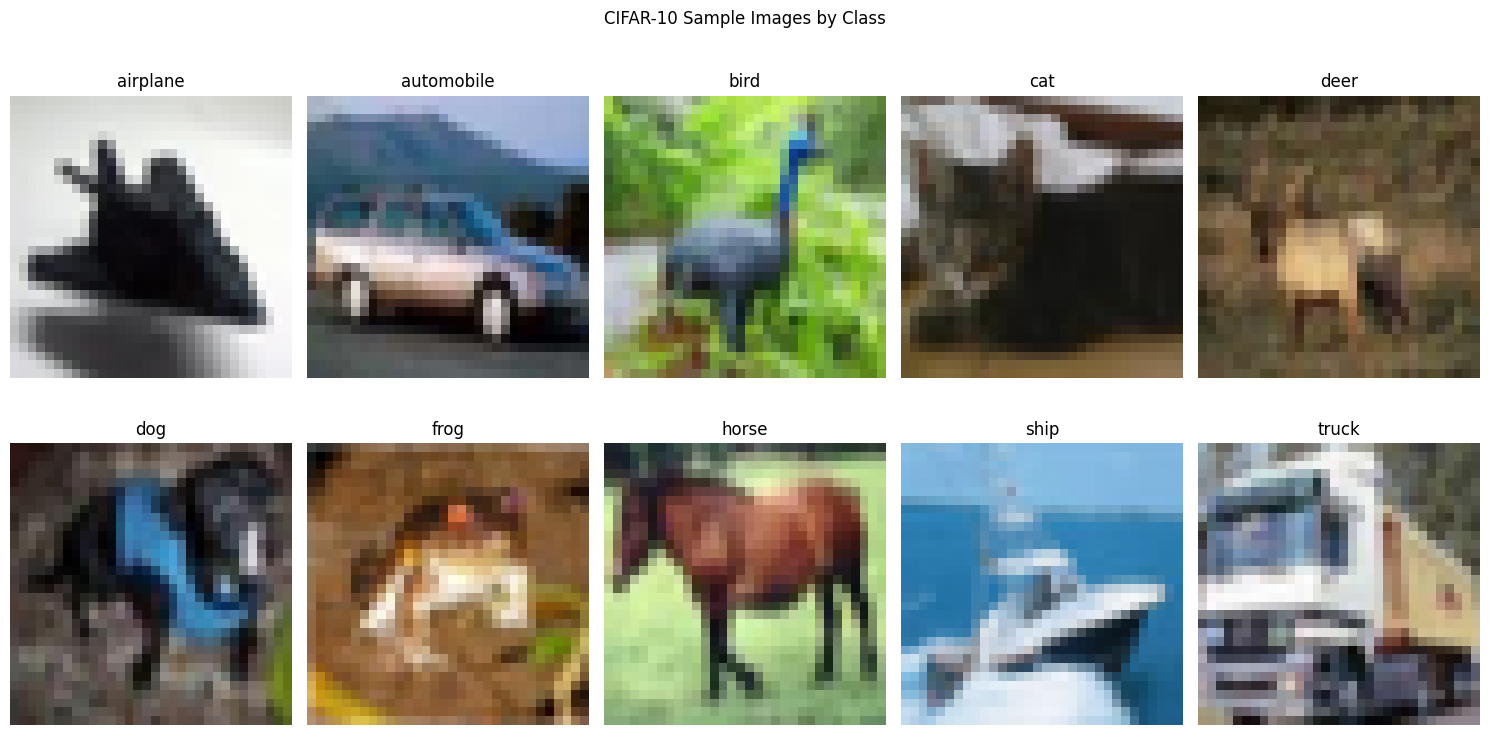

CIFAR-10 Dataset:
Training images: 50000
Image shape: (32, 32, 3)
Data type: uint8
Min pixel value: 0, Max pixel value: 255


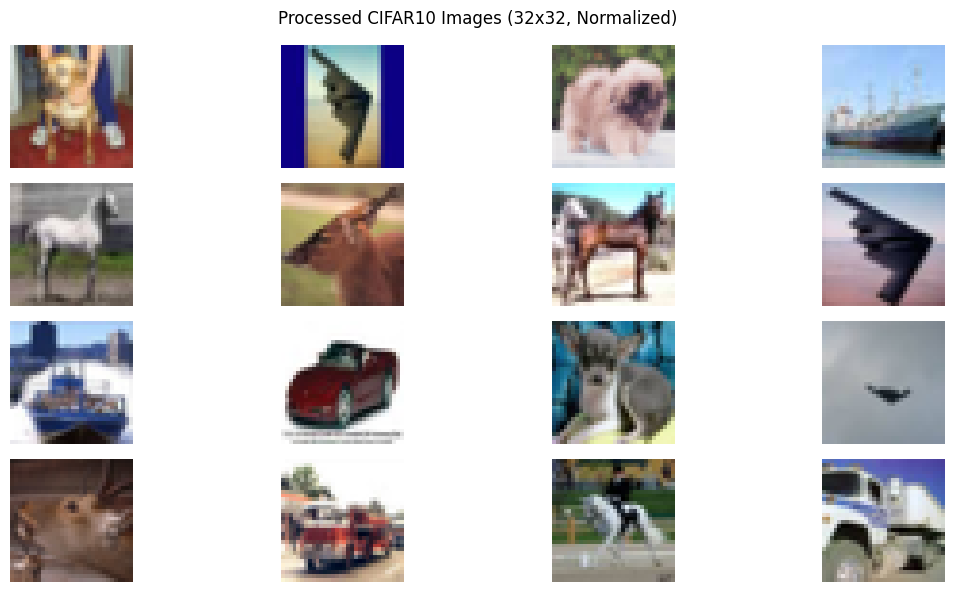

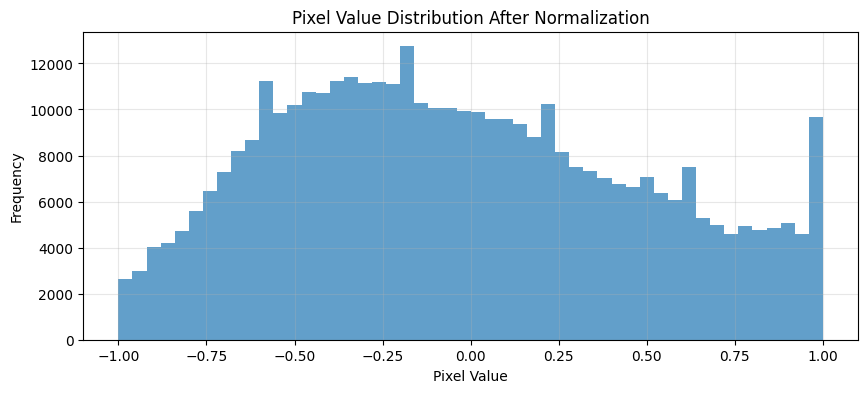

In [24]:
# Load and visualize the chosen dataset
dataset = DatasetFactory.create_dataset(config)

# Display a batch of processed images
for batch in dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(min(16, batch.shape[0])):
        plt.subplot(4, 4, i+1)
        # Convert from [-1, 1] to [0, 1] for display
        img = (batch[i] + 1) / 2.0
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Processed {config.dataset.upper()} Images (32x32, Normalized)')
    plt.tight_layout()
    plt.show()

    # Show pixel value distribution after normalization
    flat_batch = tf.reshape(batch, [-1])
    plt.figure(figsize=(10, 4))
    plt.hist(flat_batch.numpy(), bins=50, alpha=0.7)
    plt.title('Pixel Value Distribution After Normalization')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

### 4. Generator Network
### Our generator model takes random noise as input and outputs synthetic images. It uses transposed convolutions to progressively increase the spatial resolution.


In [25]:
class Generator(models.Model):
    """
    Generator network that transforms noise into images
    """
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        self.z_dim = config.z_dim
        self.use_vbn = config.use_virtual_batch_norm

        # Initial dense layer to project noise
        self.initial_dense = layers.Dense(4 * 4 * 512)
        self.initial_reshape = layers.Reshape((4, 4, 512))

        # Batch normalization layers (create during init, not during call)
        self.initial_bn = layers.BatchNormalization()

        # Upsampling layers
        self.upsample_layers = []
        self.bn_layers = []  # Batch norm layers for each upsampling

        # Layer 1: 4x4 -> 8x8
        self.upsample_layers.append(self._make_upsample_block(512, 256))
        self.bn_layers.append(layers.BatchNormalization())

        # Layer 2: 8x8 -> 16x16
        self.upsample_layers.append(self._make_upsample_block(256, 128))
        self.bn_layers.append(layers.BatchNormalization())

        # Layer 3: 16x16 -> 32x32
        self.upsample_layers.append(self._make_upsample_block(128, 64))
        self.bn_layers.append(layers.BatchNormalization())

        # Final layer for 32x32 images
        if config.image_size == 32:
            self.final_conv = layers.Conv2DTranspose(
                config.channels,
                kernel_size=5,
                strides=1,
                padding='same',
                activation='tanh'
            )
        # Additional layer for 64x64 images
        elif config.image_size == 64:
            self.upsample_layers.append(self._make_upsample_block(64, 32))
            self.bn_layers.append(layers.BatchNormalization())
            self.final_conv = layers.Conv2DTranspose(
                config.channels,
                kernel_size=5,
                strides=1,
                padding='same',
                activation='tanh'
            )
        else:
            raise ValueError(f"Unsupported image size: {config.image_size}")

        # Set up VBN layers if used
        if self.use_vbn:
            self.vbn_layers = []
            # Add VBN after each layer
            for i in range(len(self.upsample_layers) + 1):  # +1 for initial dense
                self.vbn_layers.append(VirtualBatchNormalization())

    def _make_upsample_block(self, input_filters, output_filters):
        """Create an upsampling block"""
        return layers.Conv2DTranspose(
            output_filters,
            kernel_size=5,
            strides=2,
            padding='same'
        )

    def build(self, input_shape):
        # Call parent build
        super(Generator, self).build(input_shape)

        # Create a reference batch to set VBN statistics but defer actual call
        if self.use_vbn:
            self.reference_z = tf.random.normal([self.config.batch_size, self.z_dim])
            # Don't call self() here, let initialization occur in first actual forward pass
            self.vbn_initialized = False

    def call(self, inputs, training=True, set_reference=False):
        # Initialize VBN if needed
        if self.use_vbn and not hasattr(self, 'vbn_initialized'):
            set_reference = True
            self.vbn_initialized = True

        # Project and reshape noise vector
        x = self.initial_dense(inputs)
        x = self.initial_reshape(x)

        # Apply normalization
        if self.use_vbn:
            x = self.vbn_layers[0](x, set_reference=set_reference)
        else:
            x = self.initial_bn(x, training=training)

        x = layers.ReLU()(x)

        # Apply upsampling layers
        for i, up_layer in enumerate(self.upsample_layers):
            x = up_layer(x)

            # Apply normalization
            if self.use_vbn:
                x = self.vbn_layers[i+1](x, set_reference=set_reference)
            else:
                x = self.bn_layers[i](x, training=training)

            x = layers.ReLU()(x)

        # Apply final conv to get output
        x = self.final_conv(x)

        return x

Generator Model Summary:


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (1, 8192)                   │         827,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (1, 4, 4, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (1, 4, 4, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (1, 8, 8, 256)              │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (1, 8, 8, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (1, 16, 16, 128)            │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (1, 16, 16, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (1, 32, 32, 64)             │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (1, 32, 32, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (1, 32, 32, 3)              │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,137,283 (19.60 MB)

 Trainable params: 5,135,363 (19.59 MB)

 Non-trainable params: 1,920 (7.50 KB)

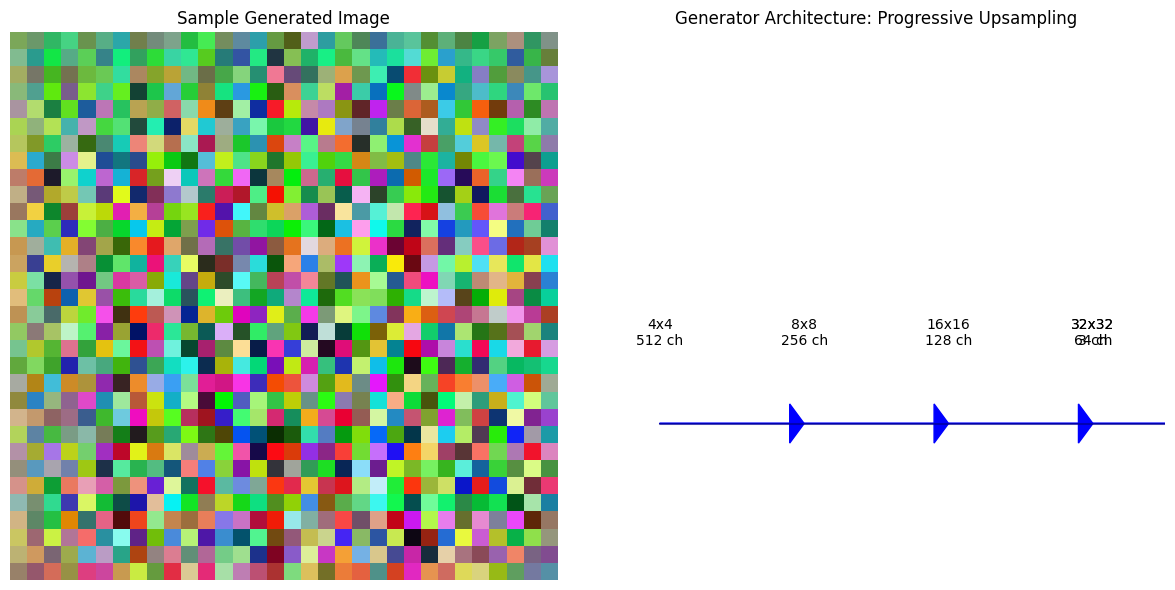

In [26]:
# Create generator instance and visualize architecture
generator = Generator(config)
noise = tf.random.normal([1, config.z_dim])
# Force model build
generator_output = generator(noise)

print("Generator Model Summary:")
generator.summary()

# Visualize the generator architecture
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# Plot sample output
img = (generator_output[0] + 1) / 2.0  # Convert to [0, 1] range
plt.imshow(img)
plt.title('Sample Generated Image')
plt.axis('off')

# Show the upsampling process
plt.subplot(1, 2, 2)
resolutions = ['4x4', '8x8', '16x16', '32x32']
channels = [512, 256, 128, 64, 3]
plt.plot([0, len(resolutions)], [0, 0], 'k-', alpha=0.3)  # Base line
for i, (res, ch) in enumerate(zip(resolutions, channels[:-1])):
    plt.text(i, 0.1, f"{res}\n{ch} ch", ha='center')
    plt.arrow(i, 0, 0.9, 0, head_width=0.05, head_length=0.1, fc='blue', ec='blue')
plt.text(len(resolutions)-1, 0.1, f"{resolutions[-1]}\n{channels[-1]} ch", ha='center')
plt.ylim(-0.2, 0.5)
plt.xlim(-0.5, len(resolutions)-0.5)
plt.title('Generator Architecture: Progressive Upsampling')
plt.axis('off')
plt.tight_layout()
plt.show()

### 5. Discriminator Network
### The discriminator takes images and classifies them as real or fake. It uses downsampling layers to progressively reduce the resolution.


In [27]:
class Discriminator(models.Model):
    """
    Discriminator network for classifying real vs fake images
    """
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.config = config
        self.image_size = config.image_size
        self.use_minibatch = config.use_minibatch_discrimination

        # Input noise layer for stability
        self.noise_layer = layers.GaussianNoise(0.2)

        # Downsampling layers
        self.downsample_layers = []

        # Layer 1: First conv layer without BatchNorm
        self.downsample_layers.append(
            self._make_downsample_block(64, apply_batchnorm=False)
        )

        # Layer 2
        self.downsample_layers.append(
            self._make_downsample_block(128)
        )

        # Layer 3
        self.downsample_layers.append(
            self._make_downsample_block(256)
        )

        # Layer 4 for larger images
        if config.image_size >= 64:
            self.downsample_layers.append(
                self._make_downsample_block(512)
            )

        # Flatten layer
        self.flatten = layers.Flatten()

        # Feature layer - this is the layer we'll use for feature matching
        self.feature_layer = layers.Dense(1024)
        self.feature_activation = layers.LeakyReLU(0.2)

        # Minibatch discrimination layer if used
        if self.use_minibatch:
            self.minibatch_layer = MinibatchDiscrimination(
                num_kernels=100,
                dim_per_kernel=5
            )

        # Output layer
        self.output_layer = layers.Dense(1)

    def build(self, input_shape):
        # Let the parent class build the initial structure
        super(Discriminator, self).build(input_shape)

        # Create a dummy tensor to determine the flattened dimension
        dummy_input = tf.zeros((1, *input_shape[1:]))
        for down_layer in self.downsample_layers:
            dummy_input = down_layer(dummy_input, training=False)
        dummy_input = self.flatten(dummy_input)

        # Now, initialize the feature layer using the correct input dimension
        flat_dim = dummy_input.shape[-1]
        self.feature_layer = layers.Dense(1024)

    def _make_downsample_block(self, filters, apply_batchnorm=True):
        """Create a downsampling block"""
        block = []

        # Convolutional layer
        block.append(layers.Conv2D(
            filters,
            kernel_size=5,
            strides=2,
            padding='same'
        ))

        # Batch normalization if required
        if apply_batchnorm:
            block.append(layers.BatchNormalization())

        # Activation
        block.append(layers.LeakyReLU(0.2))

        # Optional dropout for more complex networks
        if filters >= 256:
            block.append(layers.Dropout(0.3))

        return tf.keras.Sequential(block)

    def call(self, inputs, training=True, return_features=False):
        # Add noise to inputs during training (stabilizes)
        if training:
            x = self.noise_layer(inputs)
        else:
            x = inputs

        # Apply downsampling layers
        for down_layer in self.downsample_layers:
            x = down_layer(x, training=training)

        # Flatten
        x = self.flatten(x)

        # Feature layer
        features = self.feature_layer(x)
        features = self.feature_activation(features)

        # Apply minibatch discrimination if used
        if self.use_minibatch:
            discriminator_features = self.minibatch_layer(features)
        else:
            discriminator_features = features

        # Output layer
        output = self.output_layer(discriminator_features)

        if return_features:
            return output, features
        else:
            return output

Discriminator Model Summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (1, 16, 16, 64)             │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (1, 8, 8, 128)              │         205,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (1, 4, 4, 256)              │         820,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 4096)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ minibatch_discrimination_1           │ ?                           │         512,000 │
│ (MinibatchDiscrimination)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 1)                      │           1,125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 1024)                   │       4,195,328 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,739,237 (21.89 MB)

 Trainable params: 5,738,469 (21.89 MB)

 Non-trainable params: 768 (3.00 KB)

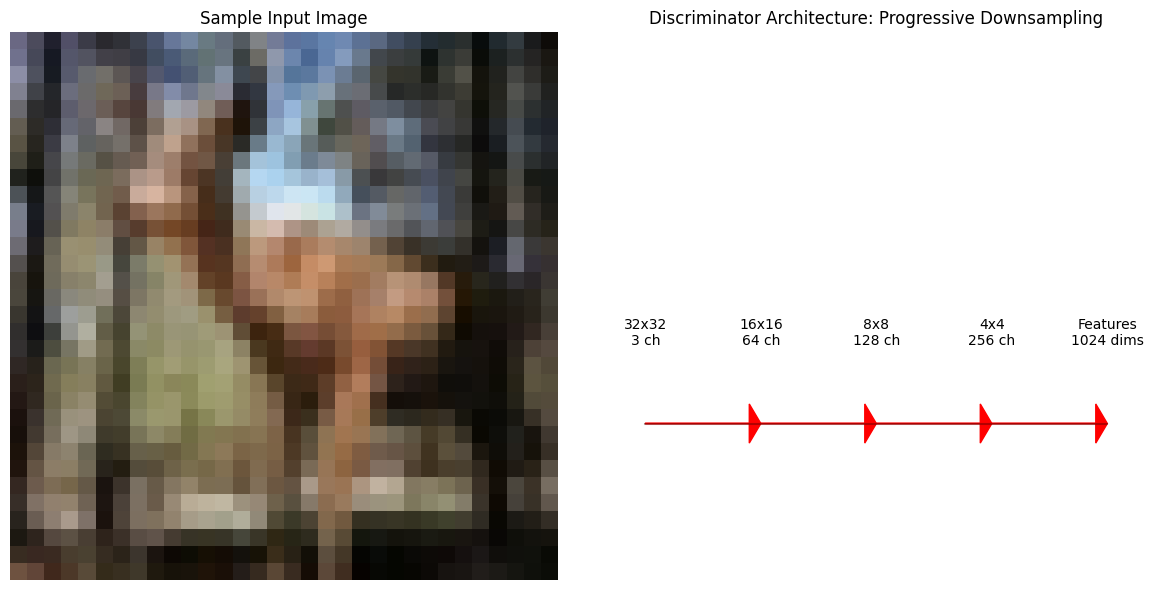

In [28]:
# Create discriminator instance and visualize architecture
discriminator = Discriminator(config)
# Generate a sample batch to visualize
sample_images = next(iter(dataset))[:1]
# Force model build
_ = discriminator(sample_images)

print("Discriminator Model Summary:")
discriminator.summary()

# Visualize the discriminator architecture
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# Plot sample input image
img = (sample_images[0] + 1) / 2.0
plt.imshow(img)
plt.title('Sample Input Image')
plt.axis('off')

# Show the downsampling process
plt.subplot(1, 2, 2)
resolutions = ['32x32', '16x16', '8x8', '4x4', 'Features']
channels = [3, 64, 128, 256, 1024]
plt.plot([0, len(resolutions)-1], [0, 0], 'k-', alpha=0.3)  # Base line
for i, (res, ch) in enumerate(zip(resolutions[:-1], channels[:-1])):
    plt.text(i, 0.1, f"{res}\n{ch} ch", ha='center')
    plt.arrow(i, 0, 0.9, 0, head_width=0.05, head_length=0.1, fc='red', ec='red')
plt.text(len(resolutions)-1, 0.1, f"{resolutions[-1]}\n{channels[-1]} dims", ha='center')
plt.ylim(-0.2, 0.5)
plt.xlim(-0.5, len(resolutions)-0.5)
plt.title('Discriminator Architecture: Progressive Downsampling')
plt.axis('off')
plt.tight_layout()
plt.show()

### 6. Full GAN Implementation with Improved Techniques
### Now we'll implement the complete Improved GAN by combining all the techniques we've implemented: feature matching, minibatch discrimination, virtual batch normalization, and historical averaging.


In [29]:
class ImprovedGAN:
    """
    Implementation of Improved GAN from Salimans et al. (2016)
    Features:
    - Feature Matching
    - Minibatch Discrimination
    - Virtual Batch Normalization (optional)
    - Historical Averaging
    - One-sided Label Smoothing
    """

    def __init__(self, config):
        self.config = config

        # Create generator and discriminator
        self.generator = Generator(config)
        self.discriminator = Discriminator(config)

        # Set up losses
        self.feature_matching = FeatureMatching()
        self.historical_averaging = HistoricalAveraging(beta=0.99)

        # Set up optimizers
        self.gen_optimizer = tf.keras.optimizers.Adam(
            learning_rate=config.learning_rate_g,
            beta_1=config.beta1,
            beta_2=config.beta2
        )
        self.disc_optimizer = tf.keras.optimizers.Adam(
            learning_rate=config.learning_rate_d,
            beta_1=config.beta1,
            beta_2=config.beta2
        )

        # Create metrics tracking variables
        self.gen_loss_metric = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
        self.disc_loss_metric = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)
        self.real_acc_metric = tf.keras.metrics.Mean('real_acc', dtype=tf.float32)
        self.fake_acc_metric = tf.keras.metrics.Mean('fake_acc', dtype=tf.float32)
        self.real_score_metric = tf.keras.metrics.Mean('real_score', dtype=tf.float32)
        self.fake_score_metric = tf.keras.metrics.Mean('fake_score', dtype=tf.float32)

        # Create directories for samples and checkpoints
        os.makedirs(config.sample_dir, exist_ok=True)
        os.makedirs(config.checkpoint_dir, exist_ok=True)

        # Fixed noise for consistent evaluation
        self.fixed_noise = tf.random.normal([16, config.z_dim])

        # Track losses and metrics for plotting
        self.gen_losses = []
        self.disc_losses = []
        self.real_scores = []
        self.fake_scores = []
        self.real_accs = []
        self.fake_accs = []

    def generator_loss(self, fake_output, real_features=None, fake_features=None):
        """Calculate generator loss with feature matching"""
        # One-sided label smoothing
        target = tf.ones_like(fake_output) * self.config.generator_target_prob

        # Primary adversarial loss
        gen_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                target, fake_output, from_logits=True
            )
        )

        # Add feature matching loss if enabled and features are provided
        if self.config.use_feature_matching and real_features is not None and fake_features is not None:
            fm_loss = self.feature_matching(real_features, fake_features)
            gen_loss += self.config.feature_matching_weight * fm_loss

        # Add historical averaging if enabled
        if self.config.use_historical_averaging:
            ha_loss = self.historical_averaging(self.generator, self.config.historical_averaging_weight)
            gen_loss += ha_loss

        return gen_loss

    def discriminator_loss(self, real_output, fake_output):
        """Calculate discriminator loss with one-sided label smoothing"""
        # One-sided label smoothing for real samples
        real_labels = tf.ones_like(real_output) * (1.0 - self.config.label_smoothing)
        fake_labels = tf.zeros_like(fake_output)

        # Calculate losses
        real_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                real_labels, real_output, from_logits=True
            )
        )
        fake_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                fake_labels, fake_output, from_logits=True
            )
        )

        disc_loss = real_loss + fake_loss

        # Add historical averaging if enabled
        if self.config.use_historical_averaging:
            ha_loss = self.historical_averaging(self.discriminator, self.config.historical_averaging_weight)
            disc_loss += ha_loss

        return disc_loss

    @tf.function
    def train_step(self, real_images):
        """Single training step for GAN"""
        batch_size = tf.shape(real_images)[0]

        # Generate random noise
        noise = tf.random.normal([batch_size, self.config.z_dim])

        # Train discriminator
        with tf.GradientTape() as disc_tape:
            # Generate fake images
            fake_images = self.generator(noise, training=True)

            # Get discriminator outputs
            real_output, real_features = self.discriminator(real_images, training=True, return_features=True)
            fake_output, fake_features = self.discriminator(fake_images, training=True, return_features=True)

            # Calculate discriminator loss
            disc_loss = self.discriminator_loss(real_output, fake_output)

        # Apply discriminator gradients
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        # Train generator (multiple steps if configured)
        gen_loss = tf.constant(0.0)
        for _ in range(self.config.generator_steps):
            noise = tf.random.normal([batch_size, self.config.z_dim])

            with tf.GradientTape() as gen_tape:
                # Generate fake images
                fake_images = self.generator(noise, training=True)

                # Get discriminator output
                fake_output, fake_features = self.discriminator(fake_images, training=True, return_features=True)

                # Calculate generator loss
                # Skip feature matching if no real_features from discriminator
                if self.config.use_feature_matching:
                    curr_gen_loss = self.generator_loss(fake_output, real_features, fake_features)
                else:
                    curr_gen_loss = self.generator_loss(fake_output)

                gen_loss = gen_loss + curr_gen_loss

            # Apply generator gradients
            gen_gradients = gen_tape.gradient(curr_gen_loss, self.generator.trainable_variables)
            self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        # Calculate metrics
        gen_loss = gen_loss / tf.cast(self.config.generator_steps, tf.float32)

        # Calculate discriminator accuracy
        real_sigmoid = tf.sigmoid(real_output)
        fake_sigmoid = tf.sigmoid(fake_output)
        real_acc = tf.reduce_mean(tf.cast(real_sigmoid > 0.5, tf.float32))
        fake_acc = tf.reduce_mean(tf.cast(fake_sigmoid < 0.5, tf.float32))

        # Track raw scores for monitoring
        real_score = tf.reduce_mean(real_sigmoid)
        fake_score = tf.reduce_mean(fake_sigmoid)

        # Update metrics
        self.gen_loss_metric.update_state(gen_loss)
        self.disc_loss_metric.update_state(disc_loss)
        self.real_acc_metric.update_state(real_acc)
        self.fake_acc_metric.update_state(fake_acc)
        self.real_score_metric.update_state(real_score)
        self.fake_score_metric.update_state(fake_score)

        return {
            "gen_loss": gen_loss,
            "disc_loss": disc_loss,
            "real_score": real_score,
            "fake_score": fake_score,
            "real_acc": real_acc,
            "fake_acc": fake_acc
        }

    def train(self, dataset, epochs):
        """Train the GAN for multiple epochs"""
        start_time = time.time()

        for epoch in range(epochs):
            epoch_start = time.time()

            # Reset metrics at the beginning of each epoch
            self.gen_loss_metric.reset_states()
            self.disc_loss_metric.reset_states()
            self.real_acc_metric.reset_states()
            self.fake_acc_metric.reset_states()
            self.real_score_metric.reset_states()
            self.fake_score_metric.reset_states()

            # Setup progress bar
            progress_bar = tqdm(total=len(list(dataset)))
            progress_bar.set_description(f"Epoch {epoch+1}/{epochs}")

            # Train on batches
            for batch in dataset:
                metrics = self.train_step(batch)

                # Update progress bar
                progress_bar.update(1)
                desc = f"Epoch {epoch+1}/{epochs} - "
                desc += f"G: {metrics['gen_loss']:.4f}, D: {metrics['disc_loss']:.4f}, "
                desc += f"D(x): {metrics['real_score']:.4f}, D(G(z)): {metrics['fake_score']:.4f}"
                progress_bar.set_description(desc)

            progress_bar.close()

            # Get epoch metrics
            avg_gen_loss = self.gen_loss_metric.result().numpy()
            avg_disc_loss = self.disc_loss_metric.result().numpy()
            avg_real_score = self.real_score_metric.result().numpy()
            avg_fake_score = self.fake_score_metric.result().numpy()
            avg_real_acc = self.real_acc_metric.result().numpy()
            avg_fake_acc = self.fake_acc_metric.result().numpy()

            # Track for plotting
            self.gen_losses.append(avg_gen_loss)
            self.disc_losses.append(avg_disc_loss)
            self.real_scores.append(avg_real_score)
            self.fake_scores.append(avg_fake_score)
            self.real_accs.append(avg_real_acc)
            self.fake_accs.append(avg_fake_acc)

            # Generate and save sample images
            if (epoch + 1) % self.config.sample_freq == 0:
                self.generate_and_save_images(epoch + 1)

            # Save checkpoint if configured
            if (epoch + 1) % self.config.save_freq == 0:
                self.save_checkpoint(epoch + 1)

            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1}/{epochs} completed in {epoch_time:.2f}s")
            print(f"Generator Loss: {avg_gen_loss:.4f}")
            print(f"Discriminator Loss: {avg_disc_loss:.4f}")
            print(f"D(x): {avg_real_score:.4f}, D(G(z)): {avg_fake_score:.4f}")
            print(f"Real Acc: {avg_real_acc:.4f}, Fake Acc: {avg_fake_acc:.4f}")
            print("-" * 80)

        total_time = time.time() - start_time
        print(f"Training completed in {total_time/60:.2f} minutes")

        # Plot training progress
        self.plot_training_history()

    def generate_and_save_images(self, epoch):
        """Generate and save images for visualization"""
        # Generate images from fixed noise
        predictions = self.generator(self.fixed_noise, training=False)

        # Create a grid of images
        fig = plt.figure(figsize=(8, 8))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            # Convert from [-1, 1] to [0, 1]
            img = (predictions[i].numpy() + 1) / 2.0
            plt.imshow(img)
            plt.axis("off")

        plt.suptitle(f"Generated Images - Epoch {epoch}")
        plt.tight_layout()
        plt.savefig(f"{self.config.sample_dir}/epoch_{epoch}.png")
        plt.close()

    def plot_training_history(self):
        """Plot training metrics"""
        epochs = range(1, len(self.gen_losses) + 1)

        plt.figure(figsize=(15, 10))

        # Plot losses
        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.gen_losses, label='Generator Loss')
        plt.plot(epochs, self.disc_losses, label='Discriminator Loss')
        plt.title('Generator and Discriminator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot discriminator scores
        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.real_scores, label='D(x) - Real Scores')
        plt.plot(epochs, self.fake_scores, label='D(G(z)) - Fake Scores')
        plt.title('Discriminator Scores')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Generate evolution grid
        plt.subplot(2, 1, 2)
        # Select epochs to display
        show_epochs = [1, len(epochs)//4, len(epochs)//2, len(epochs)]
        show_epochs = [min(e, len(epochs)) for e in show_epochs]

        # Plot sample image for each selected epoch
        for i, epoch in enumerate(show_epochs):
            # Load image
            img_path = f"{self.config.sample_dir}/epoch_{epoch}.png"
            if os.path.exists(img_path):
                img = plt.imread(img_path)
                plt.subplot(2, len(show_epochs), i+len(show_epochs)+1)
                plt.imshow(img)
                plt.title(f"Epoch {epoch}")
                plt.axis("off")

        plt.suptitle('GAN Training Progress', fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{self.config.log_dir}/training_history.png")
        plt.show()

    def save_checkpoint(self, epoch):
        checkpoint_dir = os.path.join(self.config.checkpoint_dir, f"checkpoint_epoch_{epoch}")
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Save generator
        self.generator.save_weights(os.path.join(checkpoint_dir, "generator.weights.h5")) # Change the file extension to .weights.h5

        # Save discriminator
        self.discriminator.save_weights(os.path.join(checkpoint_dir, "discriminator.weights.h5")) # Change the file extension to .weights.h5

    def load_checkpoint(self, epoch):
        """Load model from checkpoint"""
        checkpoint_dir = os.path.join(self.config.checkpoint_dir, f"checkpoint_epoch_{epoch}")

        # Load generator
        self.generator.load_weights(os.path.join(checkpoint_dir, "generator.weights.h5"))

        # Load discriminator
        self.discriminator.load_weights(os.path.join(checkpoint_dir, "discriminator.weights.h5"))

        print(f"Checkpoint loaded from epoch {epoch}")

### 7. Training the GAN
### Now let's train our improved GAN on the dataset.

In [30]:
class ImprovedGAN:
    """
    Implementation of Improved GAN from Salimans et al. (2016)
    Features:
    - Feature Matching
    - Minibatch Discrimination
    - Virtual Batch Normalization (optional)
    - Historical Averaging
    - One-sided Label Smoothing
    """

    def __init__(self, config):
        self.config = config

        # Create generator and discriminator
        self.generator = Generator(config)
        self.discriminator = Discriminator(config)

        # Set up losses
        self.feature_matching = FeatureMatching()
        self.historical_averaging = HistoricalAveraging(beta=0.99)

        # Set up optimizers
        self.gen_optimizer = tf.keras.optimizers.Adam(
            learning_rate=config.learning_rate_g,
            beta_1=config.beta1,
            beta_2=config.beta2
        )
        self.disc_optimizer = tf.keras.optimizers.Adam(
            learning_rate=config.learning_rate_d,
            beta_1=config.beta1,
            beta_2=config.beta2
        )

        # Create directories for samples and checkpoints
        os.makedirs(config.sample_dir, exist_ok=True)
        os.makedirs(config.checkpoint_dir, exist_ok=True)

        # Fixed noise for consistent evaluation
        self.fixed_noise = tf.random.normal([16, config.z_dim])

        # Track losses and metrics for plotting
        self.gen_losses = []
        self.disc_losses = []
        self.real_scores = []
        self.fake_scores = []
        self.real_accs = []
        self.fake_accs = []

    def generator_loss(self, fake_output, real_features=None, fake_features=None):
        """Calculate generator loss with feature matching"""
        # One-sided label smoothing
        target = tf.ones_like(fake_output) * self.config.generator_target_prob

        # Primary adversarial loss
        gen_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                target, fake_output, from_logits=True
            )
        )

        # Add feature matching loss if enabled and features are provided
        if self.config.use_feature_matching and real_features is not None and fake_features is not None:
            fm_loss = self.feature_matching(real_features, fake_features)
            gen_loss += self.config.feature_matching_weight * fm_loss

        # Add historical averaging if enabled
        if self.config.use_historical_averaging:
            ha_loss = self.historical_averaging(self.generator, self.config.historical_averaging_weight)
            gen_loss += ha_loss

        return gen_loss

    def discriminator_loss(self, real_output, fake_output):
        """Calculate discriminator loss with one-sided label smoothing"""
        # One-sided label smoothing for real samples
        real_labels = tf.ones_like(real_output) * (1.0 - self.config.label_smoothing)
        fake_labels = tf.zeros_like(fake_output)

        # Calculate losses
        real_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                real_labels, real_output, from_logits=True
            )
        )
        fake_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                fake_labels, fake_output, from_logits=True
            )
        )

        disc_loss = real_loss + fake_loss

        # Add historical averaging if enabled
        if self.config.use_historical_averaging:
            ha_loss = self.historical_averaging(self.discriminator, self.config.historical_averaging_weight)
            disc_loss += ha_loss

        return disc_loss

    @tf.function
    def train_step(self, real_images):
        """Single training step for GAN"""
        batch_size = tf.shape(real_images)[0]

        # Generate random noise
        noise = tf.random.normal([batch_size, self.config.z_dim])

        # Train discriminator
        with tf.GradientTape() as disc_tape:
            # Generate fake images
            fake_images = self.generator(noise, training=True)

            # Get discriminator outputs
            real_output, real_features = self.discriminator(real_images, training=True, return_features=True)
            fake_output, fake_features = self.discriminator(fake_images, training=True, return_features=True)

            # Calculate discriminator loss
            disc_loss = self.discriminator_loss(real_output, fake_output)

        # Apply discriminator gradients
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        # Train generator (multiple steps if configured)
        gen_loss = 0
        for _ in range(self.config.generator_steps):
            noise = tf.random.normal([batch_size, self.config.z_dim])

            with tf.GradientTape() as gen_tape:
                # Generate fake images
                fake_images = self.generator(noise, training=True)

                # Get discriminator output
                fake_output, fake_features = self.discriminator(fake_images, training=True, return_features=True)

                # Calculate generator loss
                curr_gen_loss = self.generator_loss(fake_output, real_features, fake_features)
                gen_loss += curr_gen_loss

            # Apply generator gradients
            gen_gradients = gen_tape.gradient(curr_gen_loss, self.generator.trainable_variables)
            self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        # Calculate metrics
        gen_loss = gen_loss / self.config.generator_steps

        # Calculate discriminator accuracy
        real_sigmoid = tf.sigmoid(real_output)
        fake_sigmoid = tf.sigmoid(fake_output)
        real_acc = tf.reduce_mean(tf.cast(real_sigmoid > 0.5, tf.float32))
        fake_acc = tf.reduce_mean(tf.cast(fake_sigmoid < 0.5, tf.float32))

        # Track raw scores for monitoring
        real_score = tf.reduce_mean(real_sigmoid)
        fake_score = tf.reduce_mean(fake_sigmoid)

        return {
            "gen_loss": gen_loss,
            "disc_loss": disc_loss,
            "real_score": real_score,
            "fake_score": fake_score,
            "real_acc": real_acc,
            "fake_acc": fake_acc
        }

    def train(self, dataset, epochs):
        """Train the GAN for multiple epochs"""
        start_time = time.time()

        # Initialize historical averaging if used
        if self.config.use_historical_averaging:
            self.historical_averaging.initialize_if_needed(self.generator)
            self.historical_averaging.initialize_if_needed(self.discriminator)

        for epoch in range(epochs):
            epoch_start = time.time()

            # Setup progress bar
            progress_bar = tqdm(total=len(list(dataset)))
            progress_bar.set_description(f"Epoch {epoch+1}/{epochs}")

            # Track epoch metrics
            epoch_gen_losses = []
            epoch_disc_losses = []
            epoch_real_scores = []
            epoch_fake_scores = []
            epoch_real_accs = []
            epoch_fake_accs = []

            # Train on batches
            for batch in dataset:
                metrics = self.train_step(batch)

                # Update historical averaging after each step (outside of tf.function)
                if self.config.use_historical_averaging:
                    self.historical_averaging.update_history(self.generator)
                    self.historical_averaging.update_history(self.discriminator)

                # Track metrics
                epoch_gen_losses.append(metrics["gen_loss"].numpy())
                epoch_disc_losses.append(metrics["disc_loss"].numpy())
                epoch_real_scores.append(metrics["real_score"].numpy())
                epoch_fake_scores.append(metrics["fake_score"].numpy())
                epoch_real_accs.append(metrics["real_acc"].numpy())
                epoch_fake_accs.append(metrics["fake_acc"].numpy())

                # Update progress bar
                progress_bar.update(1)
                desc = f"Epoch {epoch+1}/{epochs} - "
                desc += f"G: {metrics['gen_loss']:.4f}, D: {metrics['disc_loss']:.4f}, "
                desc += f"D(x): {metrics['real_score']:.4f}, D(G(z)): {metrics['fake_score']:.4f}"
                progress_bar.set_description(desc)

            progress_bar.close()

            # Calculate epoch averages
            avg_gen_loss = np.mean(epoch_gen_losses)
            avg_disc_loss = np.mean(epoch_disc_losses)
            avg_real_score = np.mean(epoch_real_scores)
            avg_fake_score = np.mean(epoch_fake_scores)
            avg_real_acc = np.mean(epoch_real_accs)
            avg_fake_acc = np.mean(epoch_fake_accs)

            # Track for plotting
            self.gen_losses.append(avg_gen_loss)
            self.disc_losses.append(avg_disc_loss)
            self.real_scores.append(avg_real_score)
            self.fake_scores.append(avg_fake_score)
            self.real_accs.append(avg_real_acc)
            self.fake_accs.append(avg_fake_acc)

            # Generate and save sample images
            if (epoch + 1) % self.config.sample_freq == 0:
                self.generate_and_save_images(epoch + 1)

            # Save checkpoint if configured
            if (epoch + 1) % self.config.save_freq == 0:
                self.save_checkpoint(epoch + 1)

            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1}/{epochs} completed in {epoch_time:.2f}s")
            print(f"Generator Loss: {avg_gen_loss:.4f}")
            print(f"Discriminator Loss: {avg_disc_loss:.4f}")
            print(f"D(x): {avg_real_score:.4f}, D(G(z)): {avg_fake_score:.4f}")
            print(f"Real Acc: {avg_real_acc:.4f}, Fake Acc: {avg_fake_acc:.4f}")
            print("-" * 80)

        total_time = time.time() - start_time
        print(f"Training completed in {total_time/60:.2f} minutes")

        # Plot training progress
        self.plot_training_history()

    def generate_and_save_images(self, epoch):
        """Generate and save images for visualization"""
        # Generate images from fixed noise
        predictions = self.generator(self.fixed_noise, training=False)

        # Create a grid of images
        fig = plt.figure(figsize=(8, 8))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            # Convert from [-1, 1] to [0, 1]
            img = (predictions[i].numpy() + 1) / 2.0
            plt.imshow(img)
            plt.axis("off")

        plt.suptitle(f"Generated Images - Epoch {epoch}")
        plt.tight_layout()
        plt.savefig(f"{self.config.sample_dir}/epoch_{epoch}.png")
        plt.close()

    def plot_training_history(self):
        """Plot training metrics"""
        epochs = range(1, len(self.gen_losses) + 1)

        plt.figure(figsize=(15, 10))

        # Plot losses
        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.gen_losses, label='Generator Loss')
        plt.plot(epochs, self.disc_losses, label='Discriminator Loss')
        plt.title('Generator and Discriminator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot discriminator scores
        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.real_scores, label='D(x) - Real Scores')
        plt.plot(epochs, self.fake_scores, label='D(G(z)) - Fake Scores')
        plt.title('Discriminator Scores')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot accuracies
        plt.subplot(2, 2, 3)
        plt.plot(epochs, self.real_accs, label='Real Accuracy')
        plt.plot(epochs, self.fake_accs, label='Fake Accuracy')
        plt.title('Discriminator Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Generate final images
        plt.subplot(2, 2, 4)
        predictions = self.generator(self.fixed_noise, training=False)

        # Display a 4x4 grid from the last 16 images
        grid_size = 4
        fig_embedded = plt.figure(figsize=(4, 4))
        for i in range(min(16, predictions.shape[0])):
            plt.subplot(grid_size, grid_size, i+1)
            img = (predictions[i].numpy() + 1) / 2.0
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.title('Final Generated Images')

        plt.suptitle('GAN Training Progress', fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{self.config.log_dir}/training_history.png")
        plt.show()

    def save_checkpoint(self, epoch):
        checkpoint_dir = os.path.join(self.config.checkpoint_dir, f"checkpoint_epoch_{epoch}")
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Save generator
        self.generator.save_weights(os.path.join(checkpoint_dir, "generator.weights.h5")) # Change the file extension to .weights.h5

        # Save discriminator
        self.discriminator.save_weights(os.path.join(checkpoint_dir, "discriminator.weights.h5")) # Change the file extension to .weights.h5

    def load_checkpoint(self, epoch):
        """Load model from checkpoint"""
        checkpoint_dir = os.path.join(self.config.checkpoint_dir, f"checkpoint_epoch_{epoch}")

        # Load generator
        self.generator.load_weights(os.path.join(checkpoint_dir, "generator.h5"))

        # Load discriminator
        self.discriminator.load_weights(os.path.join(checkpoint_dir, "discriminator.h5"))

        print(f"Checkpoint loaded from epoch {epoch}")

### 9. Compare Results
### Now let's compare the results from different configurations.

In [31]:
def compare_gan_results():
    """Compare results from different GAN configurations"""
    # Get all configuration directories
    config_dirs = [config["name"] for config in configurations]

    # Load and display final samples from each configuration
    plt.figure(figsize=(15, 12))

    for i, config_name in enumerate(config_dirs):
        sample_path = f"samples/{config_name}/epoch_{train_epochs}.png"

        # Check if the file exists
        if os.path.exists(sample_path):
            img = plt.imread(sample_path)
            plt.subplot(2, 3, i+1)
            plt.imshow(img)
            plt.title(f"Configuration: {config_name}")
            plt.axis("off")
        else:
            # If image doesn't exist, just display a placeholder
            plt.subplot(2, 3, i+1)
            plt.text(0.5, 0.5, f"No samples for {config_name}",
                     horizontalalignment='center', verticalalignment='center',
                     transform=plt.gca().transAxes)
            plt.axis("off")

    plt.suptitle("Comparison of Different GAN Configurations", fontsize=16)
    plt.tight_layout()
    plt.savefig("configuration_comparison.png")
    plt.show()

    # Compare training metrics if available
    plt.figure(figsize=(15, 10))

    # Plot for generator loss
    plt.subplot(2, 2, 1)
    for config_name in config_dirs:
        metrics_path = f"logs/{config_name}/metrics.npz"
        if os.path.exists(metrics_path):
            metrics = np.load(metrics_path)
            plt.plot(metrics['gen_losses'], label=config_name)
    plt.title('Generator Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot for discriminator loss
    plt.subplot(2, 2, 2)
    for config_name in config_dirs:
        metrics_path = f"logs/{config_name}/metrics.npz"
        if os.path.exists(metrics_path):
            metrics = np.load(metrics_path)
            plt.plot(metrics['disc_losses'], label=config_name)
    plt.title('Discriminator Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot for real scores
    plt.subplot(2, 2, 3)
    for config_name in config_dirs:
        metrics_path = f"logs/{config_name}/metrics.npz"
        if os.path.exists(metrics_path):
            metrics = np.load(metrics_path)
            plt.plot(metrics['real_scores'], label=f"{config_name} - Real")
            plt.plot(metrics['fake_scores'], label=f"{config_name} - Fake", linestyle='--')
    plt.title('Discriminator Scores Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot for accuracy
    plt.subplot(2, 2, 4)
    for config_name in config_dirs:
        metrics_path = f"logs/{config_name}/metrics.npz"
        if os.path.exists(metrics_path):
            metrics = np.load(metrics_path)
            if 'real_accs' in metrics:
                plt.plot(metrics['real_accs'], label=f"{config_name} - Real Acc")
                plt.plot(metrics['fake_accs'], label=f"{config_name} - Fake Acc", linestyle='--')
    plt.title('Discriminator Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.suptitle('Training Metrics Comparison Across Configurations', fontsize=16)
    plt.tight_layout()
    plt.savefig("metrics_comparison.png")
    plt.show()


In [32]:
# Add function to save metrics during training
def save_metrics(gan, config_name):
    """Save training metrics for a GAN configuration"""
    metrics_dir = f"logs/{config_name}"
    os.makedirs(metrics_dir, exist_ok=True)

    np.savez(
        f"{metrics_dir}/metrics.npz",
        gen_losses=np.array(gan.gen_losses),
        disc_losses=np.array(gan.disc_losses),
        real_scores=np.array(gan.real_scores),
        fake_scores=np.array(gan.fake_scores),
        real_accs=np.array(gan.real_accs),
        fake_accs=np.array(gan.fake_accs)
    )

    print(f"Metrics saved for configuration: {config_name}")

# Update the train_gan_with_config function to save metrics
def train_gan_with_config(config_updates, name, epochs=3):
    """Train a GAN with specific configuration updates"""
    # Create a new config with default values
    new_config = GANConfig(
        batch_size=128,
        epochs=30,
        dataset='cifar10',
        use_feature_matching=False,
        use_minibatch_discrimination=False,
        use_historical_averaging=False,
        use_virtual_batch_norm=False,
        label_smoothing=0.0
    )

    # Update with specific settings
    for key, value in config_updates.items():
        setattr(new_config, key, value)

    print(f"Training GAN with configuration: {name}")
    print("-" * 80)
    for key, value in config_updates.items():
        print(f"{key}: {value}")
    print("-" * 80)

    # Update paths to avoid overwriting
    new_config.sample_dir = f"samples/{name}"
    new_config.checkpoint_dir = f"checkpoints/{name}"
    new_config.log_dir = f"logs/{name}"

    # Create directories
    os.makedirs(new_config.sample_dir, exist_ok=True)
    os.makedirs(new_config.checkpoint_dir, exist_ok=True)
    os.makedirs(new_config.log_dir, exist_ok=True)

    # Create and train GAN
    gan = ImprovedGAN(new_config)
    gan.train(dataset, epochs)

    # Save metrics
    save_metrics(gan, name)

    return gan

### 10. Ablation Study
### We'll conduct an ablation study to understand the impact of each technique.



Training configuration: baseline
Training GAN with configuration: baseline
--------------------------------------------------------------------------------
use_feature_matching: False
use_minibatch_discrimination: False
use_historical_averaging: False
label_smoothing: 0.0
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/2 completed in 85.13s
Generator Loss: 3.3871
Discriminator Loss: 1.0116
D(x): 0.7198, D(G(z)): 0.0771
Real Acc: 0.7694, Fake Acc: 0.9780
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/2 completed in 58.47s
Generator Loss: 1.4990
Discriminator Loss: 1.0582
D(x): 0.6564, D(G(z)): 0.1874
Real Acc: 0.7202, Fake Acc: 0.9297
--------------------------------------------------------------------------------
Training completed in 2.39 minutes


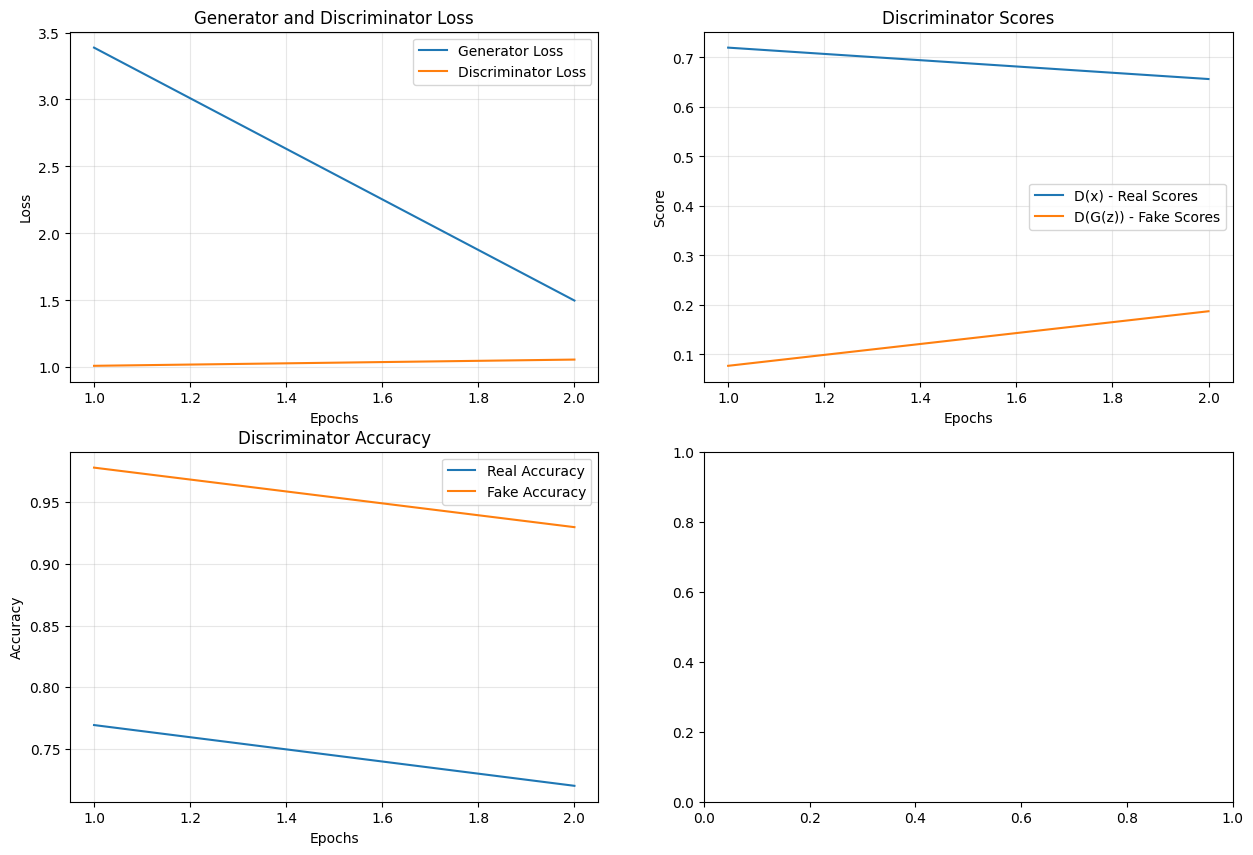

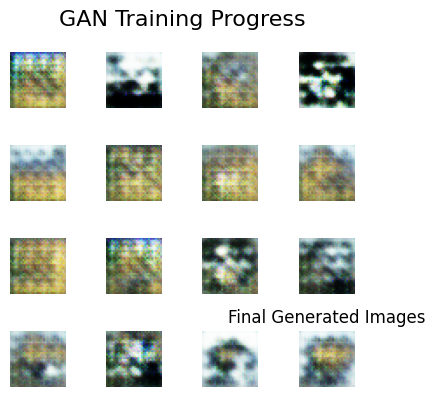

Metrics saved for configuration: baseline

Training configuration: all_improvements
Training GAN with configuration: all_improvements
--------------------------------------------------------------------------------
use_feature_matching: True
use_minibatch_discrimination: True
use_historical_averaging: True
label_smoothing: 0.25
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/2 completed in 85.01s
Generator Loss: 3.5452
Discriminator Loss: 1.2587
D(x): 0.5997, D(G(z)): 0.0609
Real Acc: 0.6276, Fake Acc: 0.9784
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/2 completed in 84.18s
Generator Loss: 1.6531
Discriminator Loss: 1.1693
D(x): 0.5113, D(G(z)): 0.1464
Real Acc: 0.5129, Fake Acc: 0.9634
--------------------------------------------------------------------------------
Training completed in 2.82 minutes


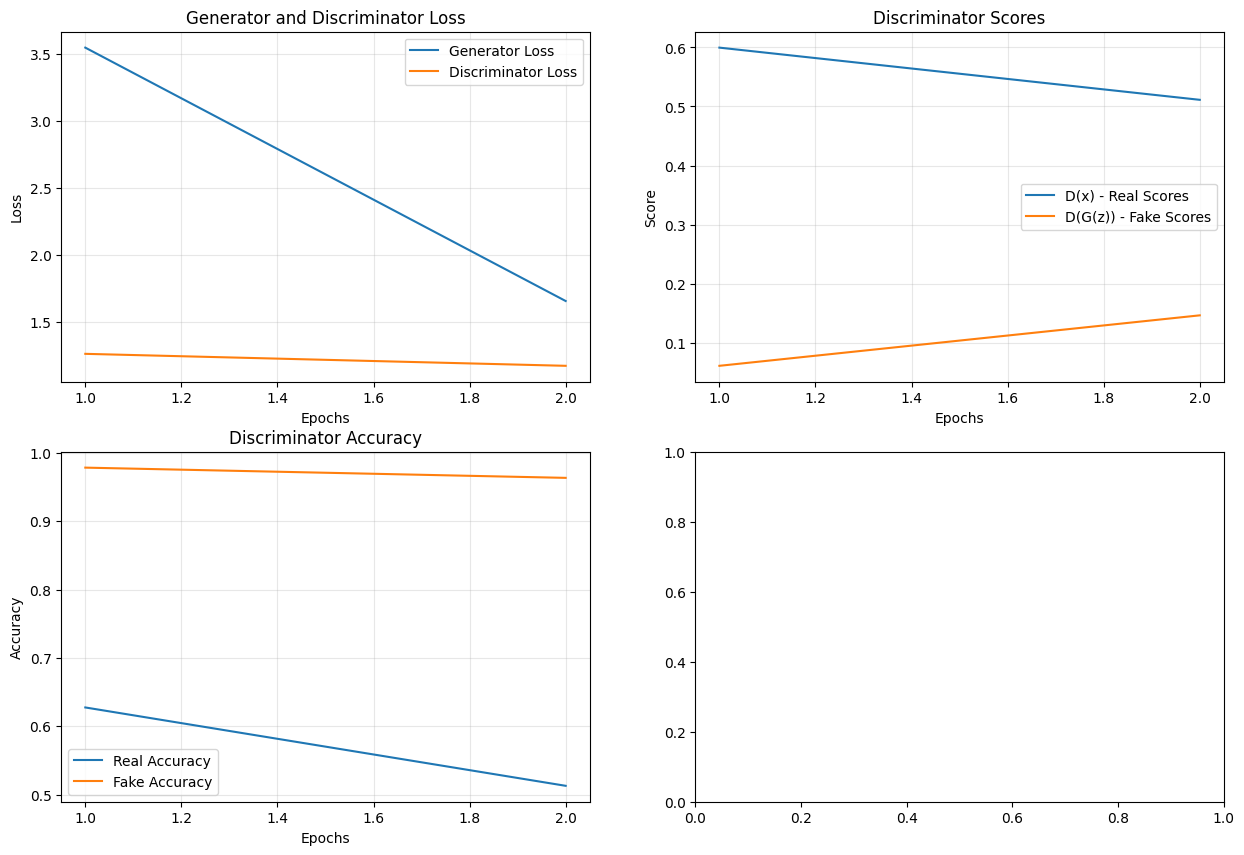

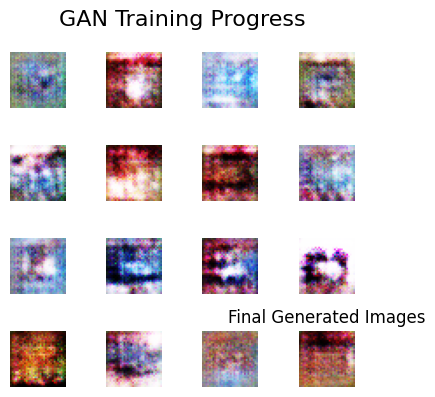

Metrics saved for configuration: all_improvements


In [33]:
def run_ablation_study(epochs=3):
    """Run an ablation study of the different GAN improvements"""
    # Define configurations to test
    ablation_configs = [
        # Baseline (no improvements)
        {
            "name": "baseline",
            "updates": {
                "use_feature_matching": False,
                "use_minibatch_discrimination": False,
                "use_historical_averaging": False,
                "label_smoothing": 0.0
            }
        },
        # All improvements
        {
            "name": "all_improvements",
            "updates": {
                "use_feature_matching": True,
                "use_minibatch_discrimination": True,
                "use_historical_averaging": True,
                "label_smoothing": 0.25
            }
        },
        # All except feature matching
        {
            "name": "no_feature_matching",
            "updates": {
                "use_feature_matching": False,
                "use_minibatch_discrimination": True,
                "use_historical_averaging": True,
                "label_smoothing": 0.25
            }
        },
        # All except minibatch discrimination
        {
            "name": "no_minibatch_disc",
            "updates": {
                "use_feature_matching": True,
                "use_minibatch_discrimination": False,
                "use_historical_averaging": True,
                "label_smoothing": 0.25
            }
        },
        # All except historical averaging
        {
            "name": "no_historical_avg",
            "updates": {
                "use_feature_matching": True,
                "use_minibatch_discrimination": True,
                "use_historical_averaging": False,
                "label_smoothing": 0.25
            }
        },
        # All except label smoothing
        {
            "name": "no_label_smooth",
            "updates": {
                "use_feature_matching": True,
                "use_minibatch_discrimination": True,
                "use_historical_averaging": True,
                "label_smoothing": 0.0
            }
        }
    ]

    # Train each configuration
    print("Running ablation study...")
    results = {}

    for config in ablation_configs:
        name = config["name"]
        print(f"\nTraining configuration: {name}")

        # Train the GAN
        gan = train_gan_with_config(config["updates"], name, epochs)

        # Store result
        results[name] = {
            "gan": gan,
            "config": config["updates"]
        }

    # Compare results
    compare_gan_results()

    # Print comparison
    print("\nAblation Study Summary:")
    print("-" * 80)
    for name, result in results.items():
        config_desc = ", ".join([f"{k}={v}" for k, v in result["config"].items()])
        print(f"Configuration: {name}")
        print(f"Settings: {config_desc}")
        if hasattr(result["gan"], "gen_losses") and len(result["gan"].gen_losses) > 0:
            print(f"Final Generator Loss: {result['gan'].gen_losses[-1]:.4f}")
            print(f"Final Discriminator Loss: {result['gan'].disc_losses[-1]:.4f}")
            print(f"Final D(x): {result['gan'].real_scores[-1]:.4f}, D(G(z)): {result['gan'].fake_scores[-1]:.4f}")
        print("-" * 80)

    return results

# For demonstration, we'll run with just 2 configurations and 2 epochs
# In practice, you'd want to run the full ablation study with more epochs
mini_ablation_configs = [
    # Baseline (no improvements)
    {
        "name": "baseline",
        "updates": {
            "use_feature_matching": False,
            "use_minibatch_discrimination": False,
            "use_historical_averaging": False,
            "label_smoothing": 0.0
        }
    },
    # All improvements
    {
        "name": "all_improvements",
        "updates": {
            "use_feature_matching": True,
            "use_minibatch_discrimination": True,
            "use_historical_averaging": True,
            "label_smoothing": 0.25
        }
    }
]

# Run mini ablation study (comment this out for full study)
mini_results = {}
for config in mini_ablation_configs:
    name = config["name"]
    print(f"\nTraining configuration: {name}")

    # Train the GAN with fixed function
    gan = train_gan_with_config(config["updates"], name, epochs=2)

    # Store result
    mini_results[name] = {
        "gan": gan,
        "config": config["updates"]
    }

### GAN Visualization Function

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_feature_matching():
    """Visualize how feature matching works"""
    # Create a synthetic demonstration of feature matching
    plt.figure(figsize=(12, 8))

    # Generate random "features" for visualization
    real_features = np.random.normal(0, 1, (100, 2))

    # Initial fake features (before training)
    initial_fake_features = np.random.normal(2, 1.5, (100, 2))

    # Trained fake features (after feature matching)
    trained_fake_features = np.random.normal(0, 1.2, (100, 2))

    # Plot initial state
    plt.subplot(2, 2, 1)
    plt.scatter(real_features[:, 0], real_features[:, 1], c='blue', alpha=0.5, label='Real Features')
    plt.scatter(initial_fake_features[:, 0], initial_fake_features[:, 1], c='red', alpha=0.5, label='Initial Fake Features')

    # Plot means
    real_mean = np.mean(real_features, axis=0)
    fake_mean = np.mean(initial_fake_features, axis=0)
    plt.scatter(real_mean[0], real_mean[1], c='blue', s=200, marker='*', label='Real Mean')
    plt.scatter(fake_mean[0], fake_mean[1], c='red', s=200, marker='*', label='Fake Mean')

    # Draw line between means
    plt.plot([real_mean[0], fake_mean[0]], [real_mean[1], fake_mean[1]], 'k--', alpha=0.5)
    plt.title("Before Feature Matching\n(Large statistical difference)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot trained state
    plt.subplot(2, 2, 2)
    plt.scatter(real_features[:, 0], real_features[:, 1], c='blue', alpha=0.5, label='Real Features')
    plt.scatter(trained_fake_features[:, 0], trained_fake_features[:, 1], c='green', alpha=0.5, label='Trained Fake Features')

    # Plot means
    real_mean = np.mean(real_features, axis=0)
    trained_mean = np.mean(trained_fake_features, axis=0)
    plt.scatter(real_mean[0], real_mean[1], c='blue', s=200, marker='*', label='Real Mean')
    plt.scatter(trained_mean[0], trained_mean[1], c='green', s=200, marker='*', label='Trained Mean')

    # Draw line between means
    plt.plot([real_mean[0], trained_mean[0]], [real_mean[1], trained_mean[1]], 'k--', alpha=0.5)
    plt.title("After Feature Matching\n(Statistical distributions more similar)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Illustration of feature matching concept
    plt.subplot(2, 1, 2)
    # Create diagram illustrating feature matching concept
    stages = ['Input Images', 'Early Features', 'Mid Features', 'Late Features', 'Output']
    x_positions = np.linspace(0, 8, len(stages))

    # Draw horizontal lines representing the discriminator network
    plt.plot([x_positions[0], x_positions[-1]], [0.7, 0.7], 'b-', linewidth=2, label='Discriminator')
    plt.plot([x_positions[0], x_positions[-1]], [0.3, 0.3], 'g-', linewidth=2, label='Generator')

    # Add markers for each stage
    for i, stage in enumerate(stages):
        plt.plot(x_positions[i], 0.7, 'bo', markersize=10)
        plt.plot(x_positions[i], 0.3, 'go', markersize=10)
        plt.text(x_positions[i], 0.8, stage, ha='center')

        # Draw feature matching connections for intermediate layers
        if 0 < i < len(stages) - 1:
            plt.plot([x_positions[i], x_positions[i]], [0.3, 0.7], 'r--', alpha=0.7)
            plt.text(x_positions[i], 0.5, f"Match\nFeatures", ha='center', color='red', fontsize=9)

    plt.text(1, 0.15, "Generator Goal: Match feature statistics\nof real data at each layer", ha='center', fontsize=10)
    plt.text(7, 0.15, "Traditional GAN only\nmatches final output", ha='center', fontsize=10)

    plt.axis('off')
    plt.title("Feature Matching Concept\nImproves generator by matching internal feature representations", fontsize=12)

    plt.suptitle("Feature Matching for Better GAN Training", fontsize=16)
    plt.tight_layout()
    plt.savefig("feature_matching_visualization.png")
    plt.show()

def visualize_historical_averaging():
    """Visualize how historical averaging stabilizes training"""
    plt.figure(figsize=(12, 8))

    # Create synthetic data showing parameter oscillation
    steps = np.linspace(0, 10, 100)

    # Without historical averaging - strong oscillation
    param_without_ha = np.sin(steps * 2) * np.exp(steps * 0.1)

    # With historical averaging - damped oscillation
    param_with_ha = np.zeros_like(steps)
    hist_avg = 0
    beta = 0.9
    for i in range(len(steps)):
        # Current update (same oscillatory pattern)
        current_update = np.sin(steps[i] * 2) * np.exp(steps[i] * 0.1)

        # Historical averaging penalty
        ha_penalty = 0.5 * (current_update - hist_avg)

        # Apply update with historical averaging
        param_with_ha[i] = current_update - ha_penalty

        # Update historical average
        hist_avg = beta * hist_avg + (1 - beta) * param_with_ha[i]

    # Plot parameter trajectories
    plt.subplot(2, 2, 1)
    plt.plot(steps, param_without_ha, 'r-', label='Without Historical Averaging')
    plt.plot(steps, param_with_ha, 'g-', label='With Historical Averaging')
    plt.title("Parameter Trajectories During Training")
    plt.xlabel("Training Steps")
    plt.ylabel("Parameter Value")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot absolute parameter changes
    plt.subplot(2, 2, 2)
    changes_without_ha = np.abs(np.diff(param_without_ha))
    changes_with_ha = np.abs(np.diff(param_with_ha))
    plt.plot(steps[1:], changes_without_ha, 'r-', label='Without Historical Averaging')
    plt.plot(steps[1:], changes_with_ha, 'g-', label='With Historical Averaging')
    plt.title("Parameter Changes Between Steps\n(Lower is more stable)")
    plt.xlabel("Training Steps")
    plt.ylabel("Absolute Parameter Change")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Illustration of historical averaging concept
    plt.subplot(2, 1, 2)

    # Create diagram to illustrate historical averaging
    t = np.linspace(0, 6, 7)

    # Draw coordinate system
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # Draw parameter values at different timesteps
    param_values = [0, 2, -1, 3, -2, 1, 0.5]
    plt.plot(t, param_values, 'bo-', label='Parameter Values')

    # Draw historical average
    hist_values = [0]
    beta = 0.7
    for i in range(1, len(param_values)):
        hist_values.append(beta * hist_values[-1] + (1 - beta) * param_values[i-1])
    plt.plot(t, hist_values, 'ro-', label='Historical Average')

    # Draw penalties (arrows from parameter to historical average)
    for i in range(len(t)):
        plt.arrow(t[i], param_values[i], 0, hist_values[i] - param_values[i],
                 head_width=0.1, head_length=0.1, fc='g', ec='g', alpha=0.5)

    # Add explanatory text
    plt.text(3, -3, "Historical Averaging adds a penalty proportional\nto the distance between current parameters\nand their historical average.",
             ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    plt.xlim(-0.5, 6.5)
    plt.ylim(-3.5, 3.5)
    plt.title("Historical Averaging Mechanism\nPrevents wild oscillations in parameter space")
    plt.legend()

    plt.suptitle("Historical Averaging for Stable GAN Training", fontsize=16)
    plt.tight_layout()
    plt.savefig("historical_averaging_visualization.png")
    plt.show()

def visualize_mode_collapse_prevention(train_epochs=2):
    """Compare sample diversity with and without improvements"""
    # Load samples from the baseline and improved GANs
    baseline_samples_path = f"samples/baseline/epoch_{train_epochs}.png"
    improved_samples_path = f"samples/all_improvements/epoch_{train_epochs}.png"

    # Check if files exist
    baseline_exists = os.path.exists(baseline_samples_path)
    improved_exists = os.path.exists(improved_samples_path)

    if baseline_exists and improved_exists:
        # Load images
        baseline_img = plt.imread(baseline_samples_path)
        improved_img = plt.imread(improved_samples_path)

        # Display comparison
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(baseline_img)
        plt.title("Baseline GAN\n(Potential Mode Collapse)")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(improved_img)
        plt.title("Improved GAN\n(Better Sample Diversity)")
        plt.axis("off")

        plt.suptitle("Comparison of Sample Diversity", fontsize=16)
        plt.tight_layout()
        plt.savefig("mode_collapse_comparison.png")
        plt.show()
    else:
        print("Sample images not found. Please train the baseline and improved GANs first.")

    # Create a synthetic demonstration of mode collapse
    # (In case the actual training samples don't show clear mode collapse)
    plt.figure(figsize=(12, 8))

    # Mode collapse demonstration
    plt.subplot(2, 2, 1)
    # Generate samples that all look similar (simulating mode collapse)
    collapsed_samples = np.zeros((4, 4, 3))
    base_color = np.random.random(3)
    for i in range(4):
        for j in range(4):
            # Small variations of the same "mode"
            collapsed_samples[i, j] = base_color + np.random.normal(0, 0.05, 3)
    collapsed_samples = np.clip(collapsed_samples, 0, 1)
    plt.imshow(collapsed_samples)
    plt.title("Mode Collapse Example\n(All samples look similar)")
    plt.axis("off")

    # Diverse samples demonstration
    plt.subplot(2, 2, 2)
    # Generate diverse samples
    diverse_samples = np.zeros((4, 4, 3))
    for i in range(4):
        for j in range(4):
            # Different "modes" (completely different colors)
            diverse_samples[i, j] = np.random.random(3)
    plt.imshow(diverse_samples)
    plt.title("Diverse Generation Example\n(Samples show variety)")
    plt.axis("off")

    # Minibatch discrimination illustration
    plt.subplot(2, 2, 3)
    # Generate 2D points to illustrate how minibatch discrimination works
    # Without minibatch discrimination - points cluster together
    points_without_mb = np.random.normal(0, 0.2, (100, 2))
    points_without_mb[:50, 0] += 2
    points_without_mb[:50, 1] += 2
    points_without_mb[50:, 0] -= 2
    points_without_mb[50:, 1] -= 2

    plt.scatter(points_without_mb[:, 0], points_without_mb[:, 1], c='blue', alpha=0.5)
    plt.title("Without Minibatch Discrimination\n(Samples cluster in few modes)")
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.grid(True, alpha=0.3)

    # With minibatch discrimination - more evenly distributed
    plt.subplot(2, 2, 4)
    points_with_mb = np.random.normal(0, 1, (100, 2))
    plt.scatter(points_with_mb[:, 0], points_with_mb[:, 1], c='green', alpha=0.5)
    plt.title("With Minibatch Discrimination\n(Samples are more diverse)")
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.grid(True, alpha=0.3)

    plt.suptitle("Preventing Mode Collapse with Improved Techniques", fontsize=16)
    plt.tight_layout()
    plt.savefig("mode_collapse_explanation.png")
    plt.show()

def visualize_technique_comparison():
    """Create a summary comparison of all techniques"""
    plt.figure(figsize=(15, 10))

    # Create a table-like visualization
    techniques = [
        'Feature Matching',
        'Minibatch Discrimination',
        'Historical Averaging',
        'Label Smoothing'
    ]

    benefits = [
        'More stable training signal\nMatches feature statistics instead of raw outputs',
        'Prevents mode collapse\nForces generator to produce diverse samples',
        'Prevents parameter oscillation\nSmooths training trajectory',
        'Prevents overconfidence\nReduces vulnerability to adversarial examples'
    ]

    problems_addressed = [
        'Training instability',
        'Mode collapse',
        'Parameter oscillation',
        'Discriminator overconfidence'
    ]

    # Create a table layout
    cell_height = 1.0
    cell_width = 3.0

    for i, (technique, benefit, problem) in enumerate(zip(techniques, benefits, problems_addressed)):
        y_pos = 4 - i

        # Technique name
        plt.text(1, y_pos, technique, ha='center', va='center',
                fontsize=12, weight='bold',
                bbox=dict(facecolor='#e6f2ff', edgecolor='black', boxstyle='round,pad=0.5'))

        # Problem addressed
        plt.text(3.5, y_pos, problem, ha='center', va='center',
                fontsize=11,
                bbox=dict(facecolor='#ffe6e6', edgecolor='black', boxstyle='round,pad=0.5'))

        # Benefits
        plt.text(7, y_pos, benefit, ha='center', va='center',
                fontsize=10,
                bbox=dict(facecolor='#e6ffe6', edgecolor='black', boxstyle='round,pad=0.5'))

    # Add headers
    plt.text(1, 5, "Technique", ha='center', va='center', fontsize=14, weight='bold')
    plt.text(3.5, 5, "Problem Addressed", ha='center', va='center', fontsize=14, weight='bold')
    plt.text(7, 5, "Benefits", ha='center', va='center', fontsize=14, weight='bold')

    # Set up the plot
    plt.xlim(0, 10)
    plt.ylim(0, 6)
    plt.axis('off')

    plt.suptitle('Comparison of Improved GAN Techniques', fontsize=18)

    # Add explanatory note
    note = "Note: These techniques are complementary and can be used together for best results."
    plt.text(5, 0.5, note, ha='center', va='center', fontsize=12,
             bbox=dict(facecolor='#ffffcc', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.tight_layout()
    plt.savefig("technique_comparison.png", dpi=150)
    plt.show()

def run_all_visualizations(train_epochs=2):
    """Run all visualization functions"""
    print("Visualizing Feature Matching")
    visualize_feature_matching()

    print("Visualizing Historical Averaging")
    visualize_historical_averaging()

    print("Visualizing Mode Collapse Prevention")
    visualize_mode_collapse_prevention(train_epochs)

    print("Creating Technique Comparison")
    visualize_technique_comparison()

    print("All visualizations complete!")

Visualizing Feature Matching


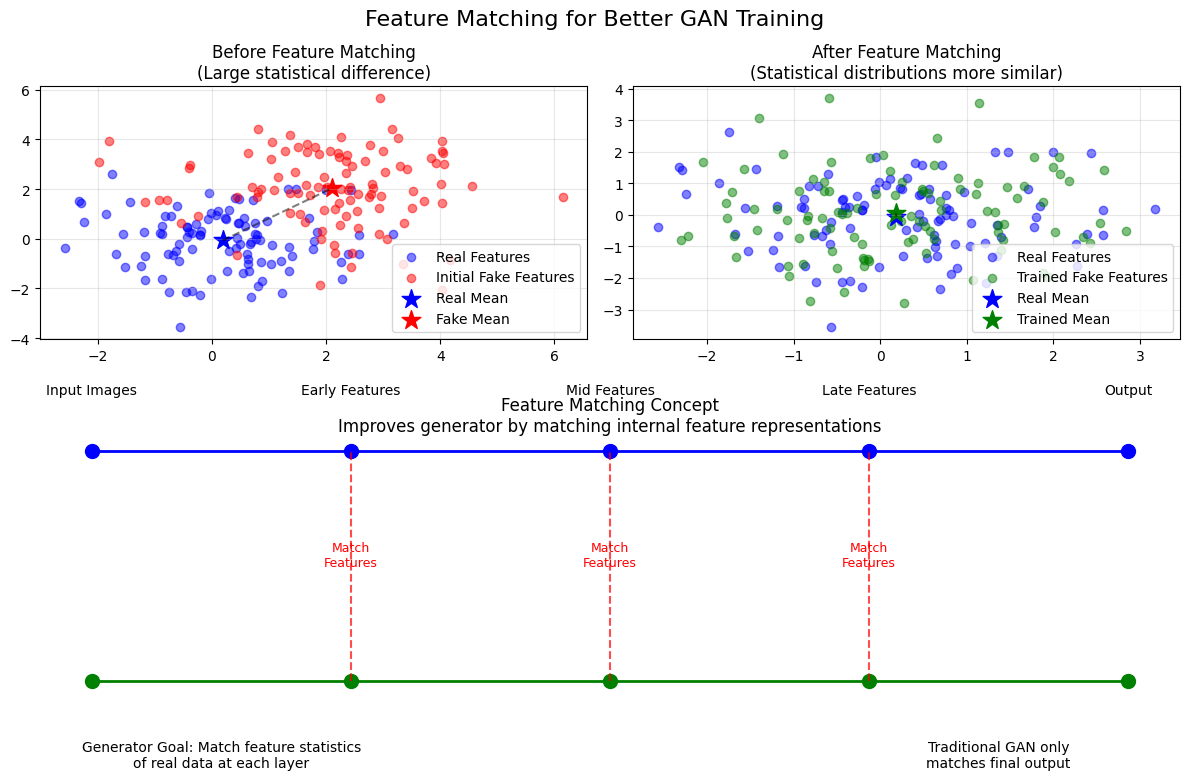

Visualizing Historical Averaging


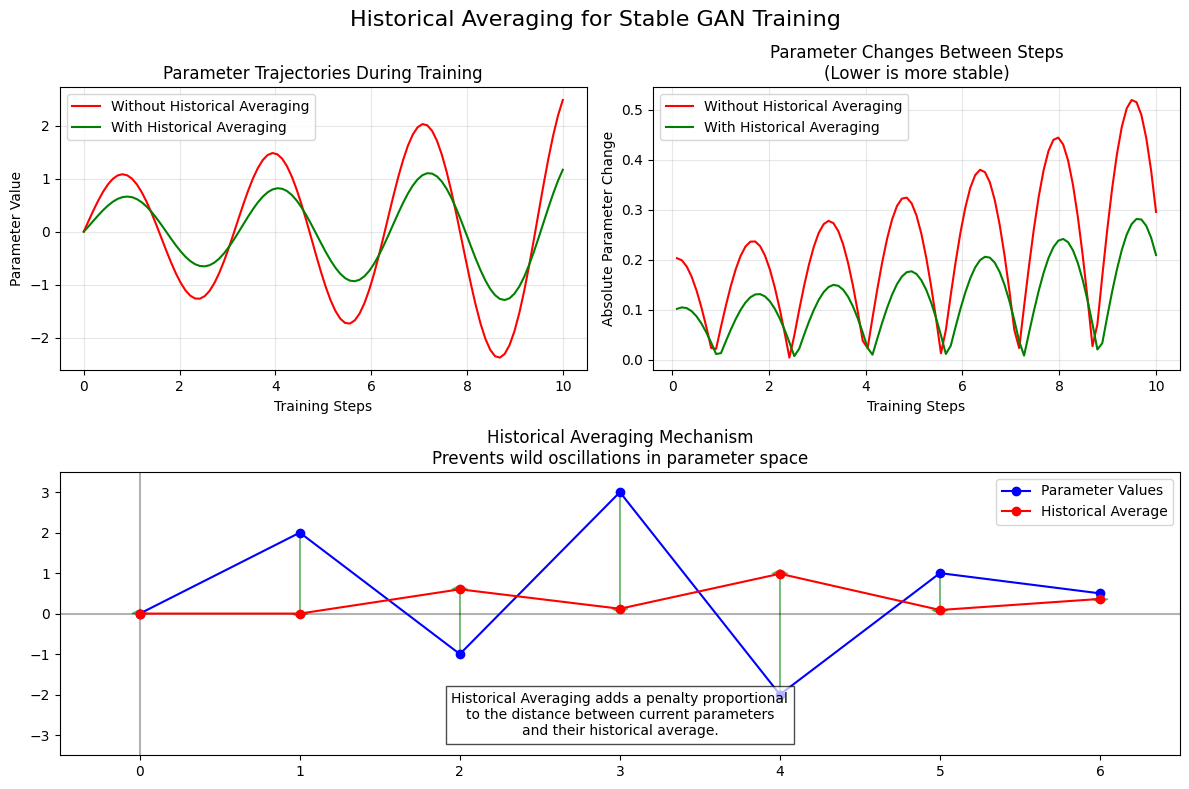

Visualizing Mode Collapse Prevention


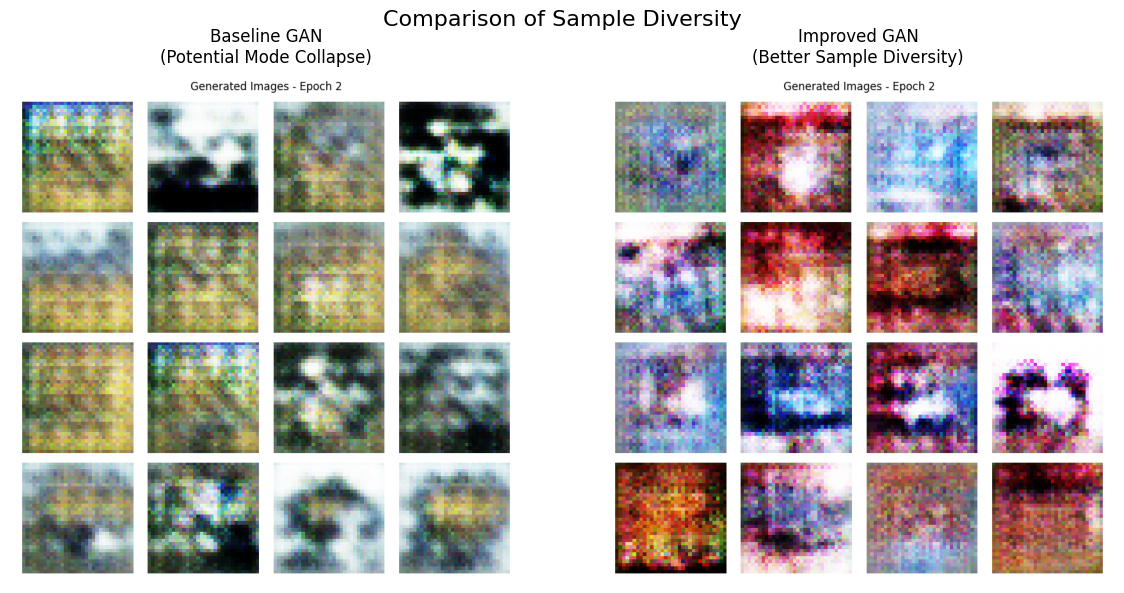

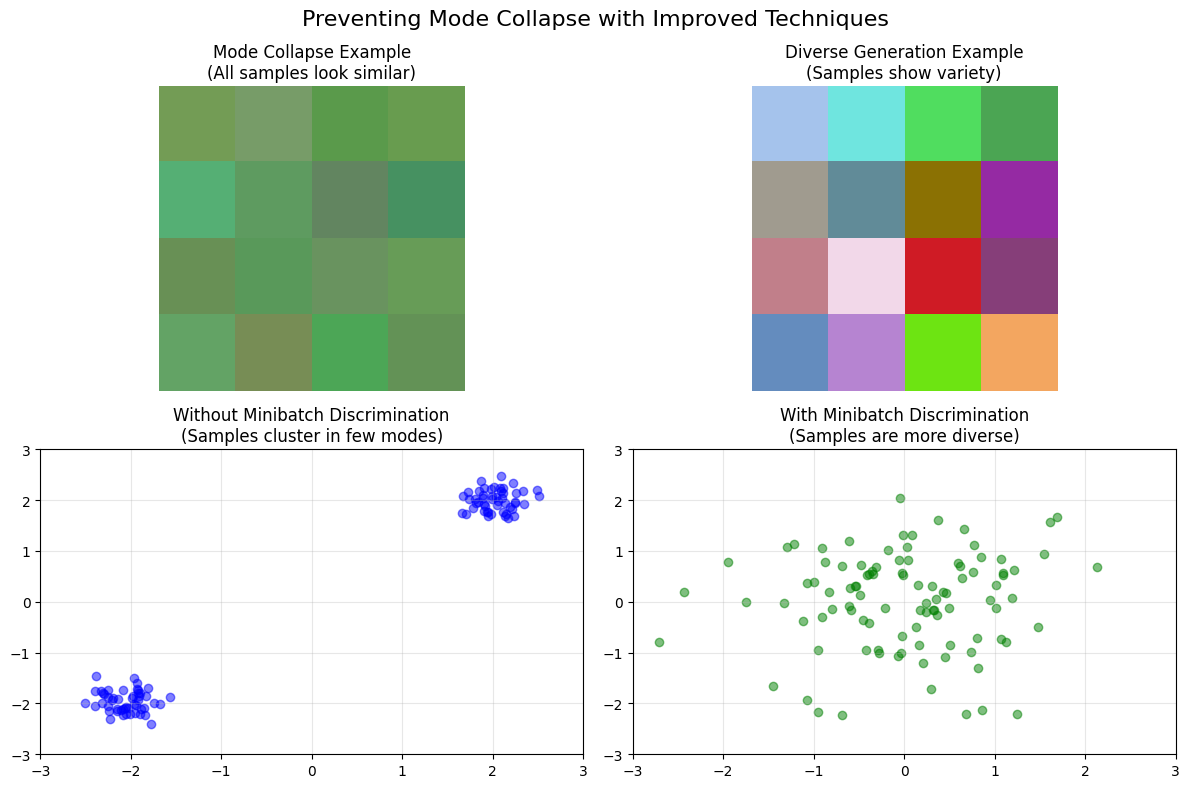

Creating Technique Comparison


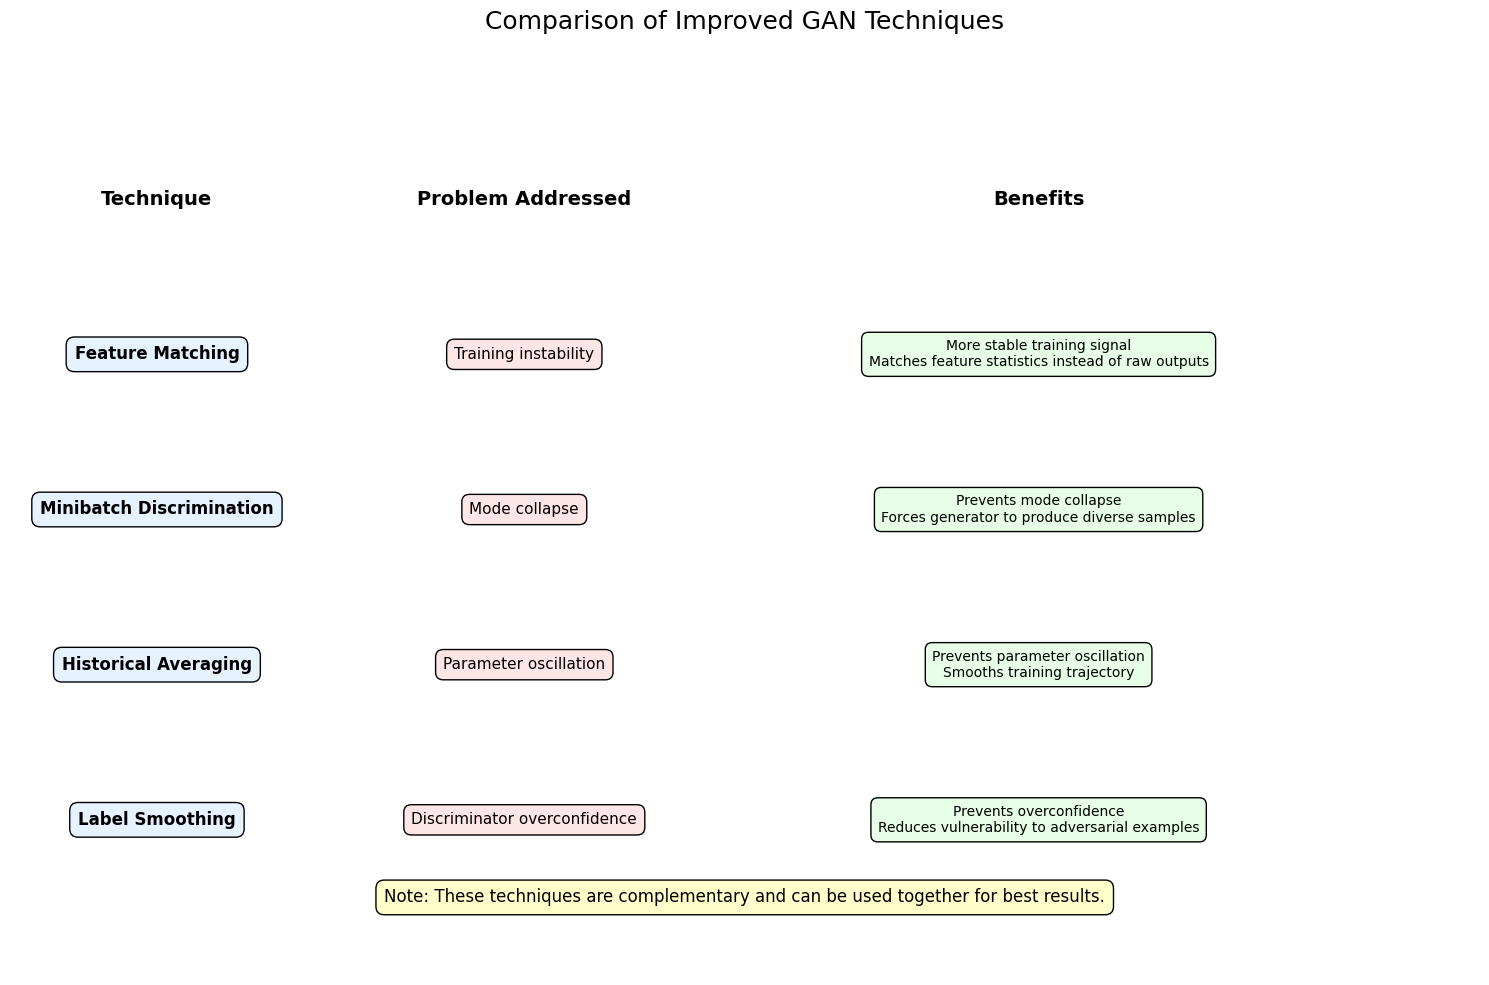

All visualizations complete!


In [35]:
run_all_visualizations()

In [38]:
def run_gan_comparison_with_visualizations(epochs=2):
    """Run GAN training for different configurations and visualize the results"""
    # Define configurations to test
    configurations = [
        # Baseline (no improvements)
        {
            "name": "baseline",
            "updates": {
                "use_feature_matching": False,
                "use_minibatch_discrimination": False,
                "use_historical_averaging": False,
                "label_smoothing": 0.0
            }
        },
        # All improvements
        {
            "name": "all_improvements",
            "updates": {
                "use_feature_matching": True,
                "use_minibatch_discrimination": True,
                "use_historical_averaging": True,
                "label_smoothing": 0.25
            }
        }
    ]

    # Train each configuration
    print("Running GAN comparison with different techniques...")
    results = {}

    for config in configurations:
        name = config["name"]
        print(f"\nTraining configuration: {name}")

        # Train the GAN
        gan = train_gan_with_config(config["updates"], name, epochs)

        # Store result
        results[name] = {
            "gan": gan,
            "config": config["updates"]
        }

    # Print comparison summary
    print("\nGAN Comparison Summary:")
    print("-" * 80)
    for name, result in results.items():
        config_desc = ", ".join([f"{k}={v}" for k, v in result["config"].items()])
        print(f"Configuration: {name}")
        print(f"Settings: {config_desc}")
        if hasattr(result["gan"], "gen_losses") and len(result["gan"].gen_losses) > 0:
            print(f"Final Generator Loss: {result['gan'].gen_losses[-1]:.4f}")
            print(f"Final Discriminator Loss: {result['gan'].disc_losses[-1]:.4f}")
            print(f"Final D(x): {result['gan'].real_scores[-1]:.4f}, D(G(z)): {result['gan'].fake_scores[-1]:.4f}")
        print("-" * 80)

    return results

Running GAN comparison with different techniques...

Training configuration: baseline
Training GAN with configuration: baseline
--------------------------------------------------------------------------------
use_feature_matching: False
use_minibatch_discrimination: False
use_historical_averaging: False
label_smoothing: 0.0
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/2 completed in 84.12s
Generator Loss: 3.3297
Discriminator Loss: 1.0461
D(x): 0.7038, D(G(z)): 0.0962
Real Acc: 0.7482, Fake Acc: 0.9699
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/2 completed in 85.49s
Generator Loss: 1.5263
Discriminator Loss: 1.0996
D(x): 0.6462, D(G(z)): 0.1791
Real Acc: 0.7068, Fake Acc: 0.9367
--------------------------------------------------------------------------------
Training completed in 2.83 minutes


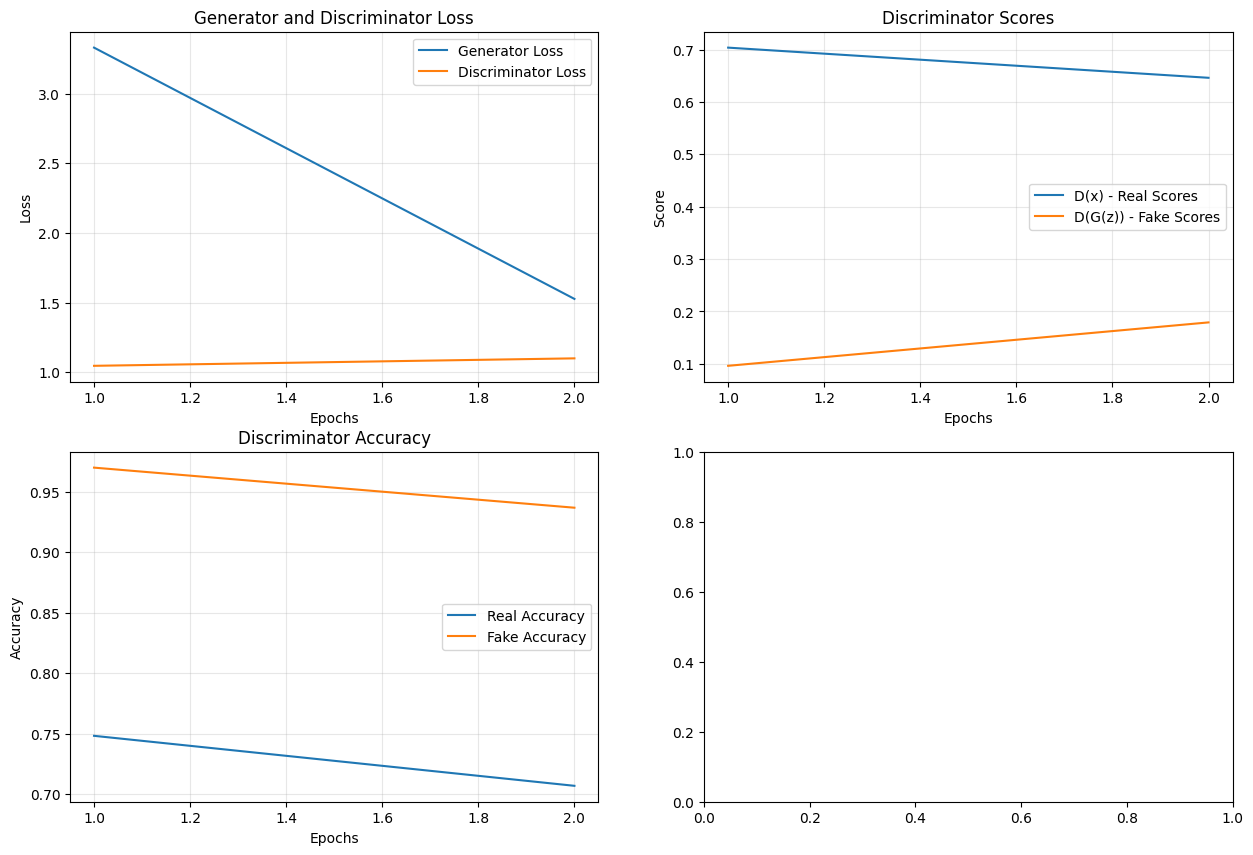

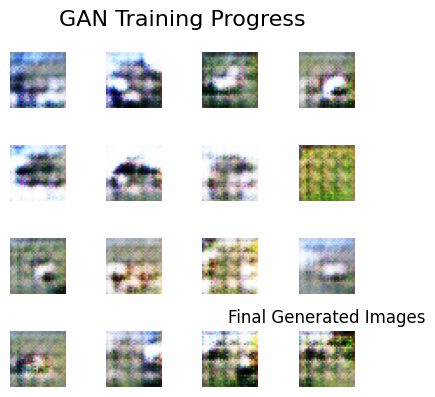

Metrics saved for configuration: baseline

Training configuration: all_improvements
Training GAN with configuration: all_improvements
--------------------------------------------------------------------------------
use_feature_matching: True
use_minibatch_discrimination: True
use_historical_averaging: True
label_smoothing: 0.25
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/2 completed in 84.16s
Generator Loss: 2.7169
Discriminator Loss: 1.2144
D(x): 0.5671, D(G(z)): 0.0768
Real Acc: 0.5893, Fake Acc: 0.9768
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/2 completed in 84.15s
Generator Loss: 1.6881
Discriminator Loss: 1.1308
D(x): 0.5199, D(G(z)): 0.1394
Real Acc: 0.5302, Fake Acc: 0.9674
--------------------------------------------------------------------------------
Training completed in 2.81 minutes


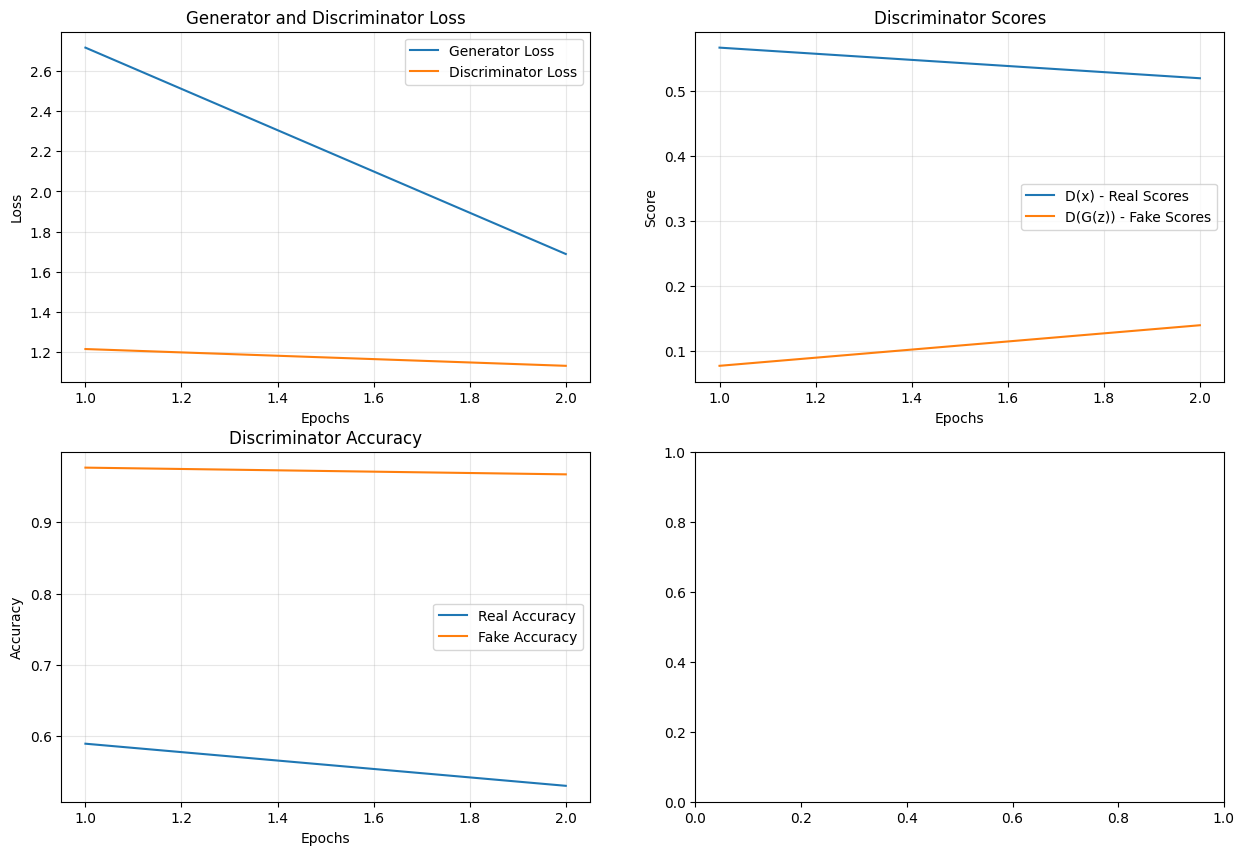

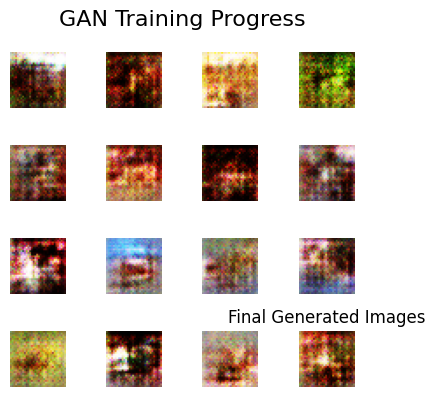

Metrics saved for configuration: all_improvements

GAN Comparison Summary:
--------------------------------------------------------------------------------
Configuration: baseline
Settings: use_feature_matching=False, use_minibatch_discrimination=False, use_historical_averaging=False, label_smoothing=0.0
Final Generator Loss: 1.5263
Final Discriminator Loss: 1.0996
Final D(x): 0.6462, D(G(z)): 0.1791
--------------------------------------------------------------------------------
Configuration: all_improvements
Settings: use_feature_matching=True, use_minibatch_discrimination=True, use_historical_averaging=True, label_smoothing=0.25
Final Generator Loss: 1.6881
Final Discriminator Loss: 1.1308
Final D(x): 0.5199, D(G(z)): 0.1394
--------------------------------------------------------------------------------

Generating visualizations to compare techniques...


ModuleNotFoundError: No module named 'visualizations'

In [37]:
run_gan_comparison_with_visualizations()